
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [1]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_19433/2063667432.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


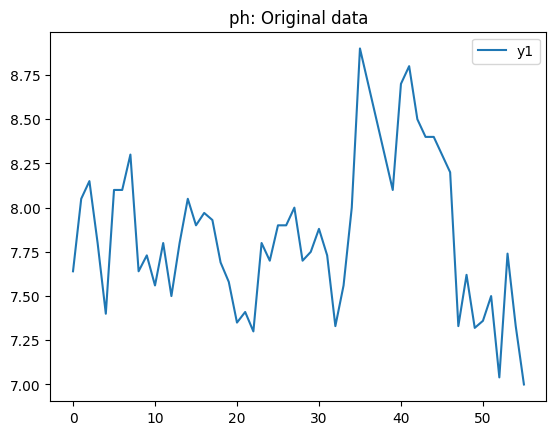

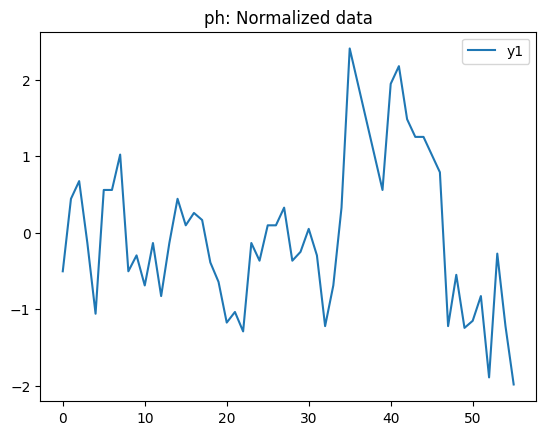

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import plotly.express as px

scaler = StandardScaler()

def getData(output, label):
    df_orig = pd.read_excel("../../../data.xlsx")
    df_orig.plot(y=[output], title=f"{label}: Original data")
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df.plot(y=[output], title=f"{label}: Normalized data")
    return (df)

def create_dataframe(output, label):
    df = getData(output, label)
    x1, x2, x3, x4, x5  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5']

    input = np.vstack([x1, x2, x3, x4, x5 ]).T
    output = np.array(df[output])
    return output, input

output, input = create_dataframe(output="y1", label="ph")



In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-03-28 20:12:56.578968: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 20:12:59.141674: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 20:12:59.141701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 20:12:59.516367: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 20:13:00.351264: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 20:13:00.353204: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error


class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
 
 
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
          self.test_prediction = self.lm_model.predict(self.test_input)

          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.test_prediction.flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()

          r2 = r2_score(self.output, pred)
          r2_test = r2_score(self.test_output, test_pred)
          r2_val = r2_score(self.val_output, val_pred)
          r2_vt = r2_score(self.vt_output, vt_pred)

          mse = mean_squared_error(self.output, pred)
          mse_test = mean_squared_error(self.test_output, test_pred)
          mse_val = mean_squared_error(self.val_output, val_pred)
          mse_vt = mean_squared_error(self.vt_output, vt_pred)

          metrics = {
                          'r2': r2,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt
                          }

          return metrics

In [6]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=5,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._train, trainer._vt, trainer._val, trainer._test), f)


  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [7]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [8]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[5], [10], [15], [20], [25], [30], [35], [40], [45]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinacao1: Hidden Size=[5], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  1.4265444810002919
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.5261561060001441
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.47648205600035
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.4301399709997895
Stopped at epoch:  6
1/1 [==============================] - 0s 52ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.4417308120000598
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.6870650799996838
Stopped at epoch:  10
1/1 [==============================] - 0s 14ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++

2024-03-28 20:18:16.044441: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_2] | 12 ++++++++++++++++++
Elapsed time:  0.3536991460000536
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_2] | 13 ++++++++++++++++++
Elapsed time:  0.35647022300008757
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [3_2] | 14 ++++++++++++++++++
Elapsed time:  0.36681420900004014
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_2] | 15 ++++++++++++++++++
Elapsed time:  0.42732831000012084
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_2] | 16 ++++++++++++++++++
Elapsed time:  0.3645332849996521
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [3_2] | 17 ++++++++++++++++++
Elapsed time:  0.3690381559999878
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [3_2] | 18 ++++++++++++++++++
Elapsed t

2024-03-28 20:18:27.189694: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Elapsed time:  0.3675644879999709
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Elapsed time:  0.33249526999998125
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Elapsed time:  0.31981429699999353
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_3] | 6 ++++++++++++++++++
Elapsed time:  0.36783185800004503
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_3] | 7 ++++++++++++++++++
Elapsed time:  0.34502635499984535
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_3] | 8 ++++++++++++++++++
Elapsed time:  0.3923389589999715
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_3] | 9 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_6_0,0.803361,-0.806806,0.802203,0.404541,0.196639,0.744267,0.256129,0.514555
model_3_6_1,0.807129,-0.778280,0.770563,0.389428,0.192871,0.732516,0.297100,0.527614
model_3_6_2,0.810312,-0.736328,0.738874,0.377669,0.189688,0.715235,0.338134,0.537776
model_3_6_3,0.813010,-0.686937,0.708323,0.368589,0.186990,0.694890,0.377695,0.545622
model_3_6_4,0.815251,-0.635223,0.679699,0.361455,0.184749,0.673588,0.414761,0.551787
model_3_6_16,0.816858,-0.331898,0.493864,0.306956,0.183142,0.548641,0.655401,0.598881
model_3_6_5,0.817028,-0.585168,0.653421,0.355557,0.182973,0.652969,0.448788,0.556884
model_3_6_15,0.817482,-0.339417,0.501630,0.310536,0.182518,0.551738,0.645343,0.595788
model_3_6_14,0.818089,-0.348615,0.510313,0.314337,0.181911,0.555527,0.634101,0.592503
model_3_6_6,0.818342,-0.539326,0.629615,0.350338,0.181658,0.634085,0.479615,0.561393


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Elapsed time:  0.37813637800036304
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Elapsed time:  0.44707387500011464
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Elapsed time:  0.3946518420002576
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Elapsed time:  0.35579743099970074
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Elapsed time:  0.379893495000033
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Elapsed time:  0.37982769200016264
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Elapsed time:  0.340463508

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_7_0,0.837337,0.499434,0.892275,0.718765,0.162663,0.612389,0.146732,0.393256
model_3_7_1,0.843972,0.489830,0.893659,0.714951,0.156028,0.624137,0.144848,0.398589
model_3_7_24,0.847011,0.322772,0.899473,0.640237,0.152989,0.828515,0.136928,0.503062
model_3_7_23,0.847549,0.325594,0.899714,0.641655,0.152451,0.825063,0.136600,0.501080
model_3_7_22,0.848128,0.328696,0.899963,0.643206,0.151872,0.821268,0.136261,0.498912
model_3_7_21,0.848749,0.332100,0.900216,0.644898,0.151251,0.817103,0.135916,0.496545
model_3_7_2,0.848849,0.479423,0.894924,0.710710,0.151151,0.636870,0.143125,0.404519
model_3_7_20,0.849411,0.335832,0.900470,0.646743,0.150589,0.812537,0.135571,0.493965
model_3_7_19,0.850115,0.339918,0.900719,0.648751,0.149885,0.807538,0.135230,0.491158
model_3_7_18,0.850855,0.344384,0.900959,0.650929,0.149145,0.802075,0.134904,0.488112


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Elapsed time:  0.3393271499999173
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Elapsed time:  0.47848207400011233
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Elapsed time:  0.34887293900010263
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Elapsed time:  0.35499983099998644
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Elapsed time:  0.3816059589998986
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Elapsed time:  0.3773328209999818
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Elapsed time:  0.355851648

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_8_13,0.802756,-0.558145,0.763166,0.432848,0.197245,0.876938,0.343122,0.625730
model_3_8_12,0.816494,-0.429160,0.781449,0.478980,0.183506,0.804344,0.316635,0.574834
model_3_8_11,0.831144,-0.287765,0.800609,0.529006,0.168856,0.724766,0.288876,0.519641
model_3_8_10,0.846246,-0.137215,0.820283,0.581822,0.153754,0.640034,0.260372,0.461370
model_3_8_9,0.861148,0.017716,0.839926,0.635802,0.138852,0.552838,0.231913,0.401815
model_3_8_8,0.875087,0.171361,0.858995,0.689080,0.124913,0.466366,0.204286,0.343034
model_3_8_0,0.875457,0.918350,0.968632,0.958565,0.124543,0.045953,0.045446,0.045715
model_3_8_7,0.887309,0.318129,0.877108,0.739910,0.112691,0.383763,0.178044,0.286954
model_3_8_1,0.893020,0.891718,0.963177,0.948002,0.106980,0.060942,0.053348,0.057369
model_3_8_6,0.897153,0.453394,0.894112,0.786947,0.102847,0.307635,0.153410,0.235058


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Elapsed time:  0.4526567339999019
Stopped at epoch:  8
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Elapsed time:  0.3017228379999324
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Elapsed time:  0.33594915200001196
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Elapsed time:  0.3431563610001831
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Elapsed time:  0.32289819800007535
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Elapsed time:  0.3355692730001465
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Elapsed time:  0.3878352149

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_9_0,0.813998,0.679150,0.370147,0.717480,0.186002,0.185532,0.219747,0.201633
model_3_9_1,0.831236,0.614786,0.359422,0.687404,0.168764,0.222751,0.223489,0.223098
model_3_9_24,0.841587,-0.045948,-0.212178,0.272495,0.158413,0.604820,0.422912,0.519216
model_3_9_23,0.842489,-0.038834,-0.203624,0.277514,0.157511,0.600707,0.419928,0.515634
model_3_9_2,0.843146,0.549737,0.333718,0.653589,0.156854,0.260365,0.232457,0.247232
model_3_9_22,0.843467,-0.030916,-0.194160,0.283088,0.156533,0.596128,0.416626,0.511656
model_3_9_21,0.844525,-0.022093,-0.183693,0.289280,0.155475,0.591026,0.412974,0.507237
model_3_9_20,0.845664,-0.012269,-0.172123,0.296156,0.154336,0.585346,0.408937,0.502330
model_3_9_19,0.846887,-0.001323,-0.159344,0.303791,0.153113,0.579016,0.404479,0.496881
model_3_9_18,0.848191,0.010878,-0.145236,0.312270,0.151809,0.571961,0.399557,0.490830


DataFrame salvo em ../results/metrics_3_9
Testando combinacao4: Hidden Size=[10], regularizer=0.1, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Elapsed time:  0.967241090999778
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Elapsed time:  0.46825541800035353
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Elapsed time:  0.3175002149996544
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Elapsed time:  0.37535532500032787
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Elapsed time:  0.3483653100001902
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Elapsed time:  0.4079147719999128
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms

2024-03-28 20:22:01.930456: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.43267020999974193
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_5] | 12 ++++++++++++++++++
Elapsed time:  0.2999061369996525
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_5] | 13 ++++++++++++++++++
Elapsed time:  0.3796076829999038
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [4_5] | 14 ++++++++++++++++++
Elapsed time:  0.3452696989998003
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_5] | 15 ++++++++++++++++++
Elapsed time:  0.3274646809995829
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_5] | 16 ++++++++++++++++++
Elapsed time:  0.3533533919999172
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_5] | 17 ++++++++++++++++++
Elapsed time:  0.3197222259996124
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/ste

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_8_13,0.801013,0.768249,0.043889,0.365404,0.198987,0.171379,1.152991,0.633314
model_4_8_12,0.811093,0.767568,0.112065,0.403905,0.188907,0.171883,1.070776,0.594891
model_4_8_11,0.821391,0.766441,0.183977,0.444355,0.178609,0.172716,0.984056,0.554523
model_4_8_10,0.831585,0.764882,0.258265,0.485986,0.168415,0.173869,0.894470,0.512976
model_4_8_9,0.841271,0.762884,0.333193,0.527809,0.158729,0.175347,0.804114,0.471237
model_4_8_0,0.843107,0.788452,0.862002,0.838540,0.156893,0.156439,0.166415,0.161134
model_4_8_8,0.849969,0.760406,0.406764,0.568673,0.150031,0.177179,0.715393,0.430456
model_4_8_1,0.853042,0.764710,0.809703,0.799487,0.146958,0.173996,0.229483,0.200108
model_4_8_7,0.857173,0.757421,0.476992,0.607436,0.142827,0.179386,0.630704,0.391771
model_4_8_2,0.859988,0.752498,0.759533,0.766169,0.140012,0.183027,0.289983,0.233359


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Elapsed time:  0.3297743260000061
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Elapsed time:  0.37663895800005776
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Elapsed time:  0.336278282999956
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Elapsed time:  0.3626074539997717
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Elapsed time:  0.35510795200025314
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Elapsed time:  0.38212017600017134
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Elapsed time:  0.2632451239

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_3_12,0.903291,0.027719,0.871565,0.672371,0.096709,0.428263,0.195165,0.318569
model_5_3_22,0.903291,0.027719,0.871565,0.672371,0.096709,0.428263,0.195165,0.318569
model_5_3_21,0.903291,0.027719,0.871565,0.672371,0.096709,0.428263,0.195165,0.318569
model_5_3_20,0.903291,0.027719,0.871565,0.672371,0.096709,0.428263,0.195165,0.318569
model_5_3_19,0.903291,0.027719,0.871565,0.672371,0.096709,0.428263,0.195165,0.318569
model_5_3_18,0.903291,0.027719,0.871565,0.672371,0.096709,0.428263,0.195165,0.318569
model_5_3_17,0.903291,0.027719,0.871565,0.672371,0.096709,0.428263,0.195165,0.318569
model_5_3_16,0.903291,0.027719,0.871565,0.672371,0.096709,0.428263,0.195165,0.318569
model_5_3_15,0.903291,0.027719,0.871565,0.672371,0.096709,0.428263,0.195165,0.318569
model_5_3_14,0.903291,0.027719,0.871565,0.672371,0.096709,0.428263,0.195165,0.318569


DataFrame salvo em ../results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Elapsed time:  0.055638226000155555
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Elapsed time:  0.030460320999736723
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Elapsed time:  0.04621448999978384
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Elapsed time:  0.04909927600010633
Stopped at epoch:  0
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Elapsed time:  0.06511741299982532
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_4] | 6 ++++++++++++++++++
Elapsed time:  0.0360106220000489
Stopped at epoch:  0
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_4] | 7 ++++++++++++++++++
Elapsed time:  0.05435

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_4_0,0.903291,0.716441,0.985897,0.886359,0.096709,0.189009,0.013012,0.106187
model_5_4_22,0.903291,0.716441,0.985897,0.886359,0.096709,0.189009,0.013012,0.106187
model_5_4_21,0.903291,0.716441,0.985897,0.886359,0.096709,0.189009,0.013012,0.106187
model_5_4_20,0.903291,0.716441,0.985897,0.886359,0.096709,0.189009,0.013012,0.106187
model_5_4_19,0.903291,0.716441,0.985897,0.886359,0.096709,0.189009,0.013012,0.106187
model_5_4_18,0.903291,0.716441,0.985897,0.886359,0.096709,0.189009,0.013012,0.106187
model_5_4_17,0.903291,0.716441,0.985897,0.886359,0.096709,0.189009,0.013012,0.106187
model_5_4_16,0.903291,0.716441,0.985897,0.886359,0.096709,0.189009,0.013012,0.106187
model_5_4_15,0.903291,0.716441,0.985897,0.886359,0.096709,0.189009,0.013012,0.106187
model_5_4_14,0.903291,0.716441,0.985897,0.886359,0.096709,0.189009,0.013012,0.106187


DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Elapsed time:  0.0595331909999004
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Elapsed time:  0.05804557599958571
Stopped at epoch:  0
1/1 [==============================] - 0s 38ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Elapsed time:  0.06632360300000073
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Elapsed time:  0.051415064000138955
Stopped at epoch:  0
1/1 [==============================] - 0s 27ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Elapsed time:  0.052758238000023994
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Elapsed time:  0.034465432000160945
Stopped at epoch:  0
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Elapsed time:  0.0526

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_5_0,0.903291,0.755287,0.823179,0.81701,0.096709,0.222403,0.15134,0.188961
model_5_5_22,0.903291,0.755287,0.823179,0.81701,0.096709,0.222403,0.15134,0.188961
model_5_5_21,0.903291,0.755287,0.823179,0.81701,0.096709,0.222403,0.15134,0.188961
model_5_5_20,0.903291,0.755287,0.823179,0.81701,0.096709,0.222403,0.15134,0.188961
model_5_5_19,0.903291,0.755287,0.823179,0.81701,0.096709,0.222403,0.15134,0.188961
model_5_5_18,0.903291,0.755287,0.823179,0.81701,0.096709,0.222403,0.15134,0.188961
model_5_5_17,0.903291,0.755287,0.823179,0.81701,0.096709,0.222403,0.15134,0.188961
model_5_5_16,0.903291,0.755287,0.823179,0.81701,0.096709,0.222403,0.15134,0.188961
model_5_5_15,0.903291,0.755287,0.823179,0.81701,0.096709,0.222403,0.15134,0.188961
model_5_5_14,0.903291,0.755287,0.823179,0.81701,0.096709,0.222403,0.15134,0.188961


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Elapsed time:  0.3976692800001729
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Elapsed time:  0.3211693949997425
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Elapsed time:  0.35925749099988025
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Elapsed time:  0.3779678169998988
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Elapsed time:  0.3078475669999534
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Elapsed time:  0.42493372399985674
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Elapsed time:  0.3296690710

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_6_0,0.903291,0.968938,0.971741,0.969920,0.096709,0.050177,0.027315,0.039418
model_5_6_1,0.903321,0.968917,0.971727,0.969902,0.096679,0.050210,0.027328,0.039442
model_5_6_2,0.917696,0.965816,0.962945,0.964829,0.082304,0.055220,0.035817,0.046089
model_5_6_3,0.928669,0.962660,0.952817,0.959254,0.071331,0.060319,0.045606,0.053395
model_5_6_4,0.937040,0.959466,0.942585,0.953618,0.062960,0.065477,0.055496,0.060780
model_5_6_5,0.943388,0.956225,0.932748,0.948088,0.056612,0.070713,0.065005,0.068027
model_5_6_6,0.948153,0.952947,0.923495,0.942737,0.051847,0.076008,0.073948,0.075039
model_5_6_7,0.951675,0.949667,0.914877,0.937606,0.048325,0.081306,0.082278,0.081763
model_5_6_8,0.954225,0.946431,0.906888,0.932720,0.045775,0.086534,0.090000,0.088165
model_5_6_24,0.955187,0.914907,0.840143,0.888980,0.044813,0.137456,0.154514,0.145484


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  0.41013539200002924
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.3571464429996922
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.4436074609998286
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.3363800560000527
Stopped at epoch:  6
1/1 [==============================] - 0s 51ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.3386151139998219
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.37166403900027944
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.3478831800

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_7_24,0.926011,0.857865,0.662161,0.791424,0.073989,0.186217,0.307403,0.243246
model_5_7_23,0.926954,0.859701,0.666711,0.794187,0.073046,0.183812,0.303262,0.240024
model_5_7_22,0.927993,0.861727,0.671746,0.797240,0.072007,0.181157,0.298681,0.236462
model_5_7_21,0.929134,0.863962,0.677314,0.800614,0.070866,0.178229,0.293615,0.232528
model_5_7_20,0.930388,0.866425,0.683466,0.804338,0.069612,0.175002,0.288017,0.228186
model_5_7_19,0.931761,0.869137,0.690255,0.808443,0.068239,0.171449,0.281839,0.223397
model_5_7_18,0.933263,0.872120,0.697739,0.812965,0.066737,0.167541,0.275029,0.218124
model_5_7_17,0.934902,0.875398,0.705978,0.817939,0.065098,0.163247,0.267533,0.212323
model_5_7_16,0.936685,0.878994,0.715029,0.823401,0.063315,0.158536,0.259298,0.205953
model_5_7_15,0.938618,0.882932,0.724953,0.829388,0.061382,0.153376,0.250267,0.198972


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Elapsed time:  0.33519826300016575
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Elapsed time:  0.35694056800002727
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Elapsed time:  0.315039693000017
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Elapsed time:  0.3511696809996465
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Elapsed time:  0.2721019270002216
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Elapsed time:  0.3149934790003499
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Elapsed time:  0.34234897399

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_8_0,0.938461,0.899537,0.969513,0.945088,0.061539,0.042555,0.026516,0.035007
model_5_8_1,0.947138,0.889976,0.965473,0.939131,0.052862,0.046605,0.030030,0.038805
model_5_8_24,0.949464,0.581662,0.825068,0.740535,0.050536,0.177205,0.152148,0.165413
model_5_8_23,0.950014,0.587034,0.827161,0.743769,0.049986,0.174929,0.150327,0.163351
model_5_8_22,0.950612,0.592951,0.829483,0.747341,0.049388,0.172423,0.148307,0.161074
model_5_8_21,0.951261,0.599461,0.832057,0.751284,0.048739,0.169665,0.146068,0.158561
model_5_8_20,0.951960,0.606616,0.834910,0.755632,0.048040,0.166634,0.143587,0.155788
model_5_8_19,0.952713,0.614469,0.838070,0.760424,0.047287,0.163308,0.140838,0.152734
model_5_8_2,0.953149,0.875792,0.957937,0.929303,0.046851,0.052613,0.036584,0.045070
model_5_8_18,0.953517,0.623075,0.841569,0.765697,0.046483,0.159662,0.137795,0.149372


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  0.353332901000158
Stopped at epoch:  7
1/1 [==============================] - 0s 28ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.4079477739996946
Stopped at epoch:  6
1/1 [==============================] - 0s 51ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.3046988119999696
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.31081147400027476
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.28212421499983975
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.3630674659998476
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.35040576599

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_9_24,0.958840,0.818930,0.913619,0.868014,0.041160,0.175900,0.088843,0.134932
model_5_9_23,0.959347,0.821465,0.914694,0.869798,0.040653,0.173437,0.087738,0.133108
model_5_9_22,0.959901,0.824266,0.915879,0.871768,0.040099,0.170716,0.086519,0.131094
model_5_9_21,0.960504,0.827359,0.917184,0.873942,0.039496,0.167712,0.085177,0.128872
model_5_9_20,0.961160,0.830769,0.918619,0.876337,0.038840,0.164399,0.083701,0.126423
model_5_9_19,0.961870,0.834528,0.920195,0.878974,0.038130,0.160747,0.082080,0.123727
model_5_9_18,0.962636,0.838665,0.921924,0.881874,0.037364,0.156728,0.080302,0.120763
model_5_9_17,0.963459,0.843214,0.923816,0.885058,0.036541,0.152309,0.078356,0.117508
model_5_9_16,0.964339,0.848207,0.925884,0.888549,0.035661,0.147458,0.076229,0.113938
model_5_9_0,0.964441,0.991674,0.978105,0.985446,0.035559,0.008088,0.022519,0.014879


DataFrame salvo em ../results/metrics_5_9
Testando combinacao6: Hidden Size=[15], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.6406710879996353
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.43750223999995796
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.2878100739999354
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.3696802929998739
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.3599386880000566
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  0.3729978309997932
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms

2024-03-28 20:26:37.176947: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3124246009997478
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_2] | 7 ++++++++++++++++++
Elapsed time:  0.3514097870001933
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_2] | 8 ++++++++++++++++++
Elapsed time:  0.31125233400007346
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_2] | 9 ++++++++++++++++++
Elapsed time:  0.32309338100003515
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [6_2] | 10 ++++++++++++++++++
Elapsed time:  0.3804974940003376
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_2] | 11 ++++++++++++++++++
Elapsed time:  0.3440476989999297
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [6_2] | 12 ++++++++++++++++++
Elapsed time:  0.2632023019996268
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_3_21,0.801940,0.842134,-0.313439,0.440304,0.198060,0.158119,1.198104,0.647524
model_6_3_20,0.803753,0.842985,-0.297893,0.446462,0.196247,0.157267,1.183923,0.640399
model_6_3_19,0.805719,0.843896,-0.280614,0.453291,0.194281,0.156354,1.168161,0.632499
model_6_3_18,0.807846,0.844868,-0.261409,0.460862,0.192154,0.155381,1.150643,0.623740
model_6_3_17,0.810134,0.845896,-0.240066,0.469253,0.189866,0.154351,1.131174,0.614033
model_6_3_16,0.812587,0.846975,-0.216347,0.478548,0.187413,0.153271,1.109538,0.603279
model_6_3_0,0.812821,0.829007,0.724218,0.819301,0.187179,0.171267,0.251566,0.209055
model_6_3_15,0.815199,0.848094,-0.189989,0.488840,0.184801,0.152150,1.085495,0.591371
model_6_3_14,0.817962,0.849239,-0.160706,0.500231,0.182038,0.151003,1.058783,0.578193
model_6_3_13,0.820857,0.850390,-0.128184,0.512825,0.179143,0.149850,1.029116,0.563622


DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Elapsed time:  0.39987744600011865
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Elapsed time:  0.3824739389997376
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Elapsed time:  0.37975934499991126
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Elapsed time:  0.3464080520002426
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Elapsed time:  0.35015075999990586
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Elapsed time:  0.3800754369999595
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Elapsed time:  0.371006717

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_4_0,0.829481,0.878546,0.497030,0.696738,0.170519,0.073281,0.313671,0.186406
model_6_4_1,0.850652,0.896060,0.468750,0.692337,0.149348,0.062714,0.331308,0.189111
model_6_4_2,0.866626,0.910511,0.433490,0.683012,0.133374,0.053995,0.353298,0.194843
model_6_4_24,0.866889,0.787538,-0.254917,0.290423,0.133111,0.128192,0.782615,0.436156
model_6_4_23,0.868252,0.792619,-0.243284,0.298618,0.131748,0.125127,0.775360,0.431119
model_6_4_22,0.869733,0.798168,-0.230394,0.307656,0.130267,0.121779,0.767321,0.425563
model_6_4_21,0.871338,0.804213,-0.216122,0.317612,0.128662,0.118132,0.758421,0.419444
model_6_4_20,0.873070,0.810779,-0.200328,0.328565,0.126930,0.114170,0.748571,0.412711
model_6_4_19,0.874929,0.817887,-0.182868,0.340595,0.125071,0.109881,0.737682,0.405317
model_6_4_18,0.876913,0.825550,-0.163583,0.353784,0.123087,0.105258,0.725655,0.397210


DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Elapsed time:  0.5039637979998588
Stopped at epoch:  8
1/1 [==============================] - 0s 30ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Elapsed time:  0.4067435970000588
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Elapsed time:  0.33977054799970574
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Elapsed time:  0.32648784799994246
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Elapsed time:  0.48653647299988734
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Elapsed time:  0.33065581100026975
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Elapsed time:  0.30527515

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_5_0,0.921663,0.951188,0.972566,0.961349,0.078337,0.055659,0.028180,0.042728
model_6_5_1,0.932277,0.946984,0.965532,0.955978,0.067723,0.060453,0.035405,0.048666
model_6_5_2,0.940377,0.942353,0.957876,0.950101,0.059623,0.065734,0.043269,0.055162
model_6_5_3,0.946518,0.937558,0.950065,0.944068,0.053482,0.071202,0.051292,0.061832
model_6_5_4,0.951144,0.932792,0.942476,0.938147,0.048856,0.076637,0.059087,0.068378
model_6_5_5,0.954603,0.928175,0.935350,0.932509,0.045397,0.081901,0.066407,0.074610
model_6_5_6,0.957162,0.923770,0.928796,0.927238,0.042838,0.086924,0.073139,0.080437
model_6_5_7,0.959025,0.919602,0.922834,0.922355,0.040975,0.091677,0.079262,0.085835
model_6_5_24,0.959336,0.879243,0.876550,0.880079,0.040664,0.137697,0.126804,0.132571
model_6_5_23,0.959611,0.880403,0.877650,0.881193,0.040389,0.136374,0.125675,0.131339


DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Elapsed time:  0.7271304249998138
Stopped at epoch:  15
1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Elapsed time:  0.4194557519999762
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Elapsed time:  0.3687649280000187
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Elapsed time:  0.33368483100002777
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Elapsed time:  0.33103175499991266
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Elapsed time:  0.32909237900003063
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Elapsed time:  0.38685438

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_6_24,0.962014,0.578948,0.959383,0.890360,0.037986,0.172402,0.071872,0.125094
model_6_6_23,0.962145,0.580637,0.959473,0.890747,0.037855,0.171711,0.071713,0.124653
model_6_6_22,0.962290,0.582506,0.959572,0.891174,0.037710,0.170945,0.071538,0.124166
model_6_6_21,0.962449,0.584572,0.959681,0.891646,0.037551,0.170099,0.071345,0.123627
model_6_6_20,0.962625,0.586855,0.959800,0.892167,0.037375,0.169164,0.071134,0.123032
model_6_6_19,0.962818,0.589378,0.959932,0.892742,0.037182,0.168131,0.070901,0.122376
model_6_6_18,0.963030,0.592164,0.960075,0.893377,0.036970,0.166991,0.070647,0.121652
model_6_6_17,0.963263,0.595237,0.960233,0.894075,0.036737,0.165733,0.070369,0.120856
model_6_6_16,0.963518,0.598622,0.960404,0.894843,0.036482,0.164346,0.070066,0.119979
model_6_6_15,0.963796,0.602351,0.960590,0.895688,0.036204,0.162820,0.069736,0.119016


DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Elapsed time:  0.29882137500044337
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Elapsed time:  0.35130223700025454
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Elapsed time:  0.3221222610000041
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Elapsed time:  0.28956086100015455
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Elapsed time:  0.4069326179997006
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Elapsed time:  0.37875390899989725
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Elapsed time:  0.32101473

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_7_0,0.967178,0.944573,0.979553,0.975839,0.032822,0.051625,0.016394,0.035046
model_6_7_1,0.971225,0.943891,0.979201,0.975515,0.028775,0.052260,0.016677,0.035515
model_6_7_2,0.974368,0.942806,0.978375,0.974932,0.025632,0.053270,0.017339,0.036361
model_6_7_3,0.976783,0.941412,0.977193,0.974150,0.023217,0.054569,0.018287,0.037495
model_6_7_4,0.978613,0.939789,0.975751,0.973224,0.021387,0.056081,0.019443,0.038839
model_6_7_5,0.979977,0.938005,0.974132,0.972196,0.020023,0.057742,0.020741,0.040330
model_6_7_24,0.980757,0.910811,0.949805,0.956624,0.019243,0.083071,0.040246,0.062918
model_6_7_23,0.980901,0.911527,0.950420,0.957027,0.019099,0.082404,0.039753,0.062333
model_6_7_6,0.980969,0.936119,0.972405,0.971106,0.019031,0.059499,0.022126,0.041912
model_6_7_22,0.981054,0.912311,0.951095,0.957469,0.018946,0.081673,0.039212,0.061692


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.3479846110003564
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.3105337420001888
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.3064135820000047
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.3372006220001822
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.3034846919999836
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.39869625599976644
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.34952769999

2024-03-28 20:28:25.145420: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.33933794999984457
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_8] | 12 ++++++++++++++++++
Elapsed time:  0.33851910400017005
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_8] | 13 ++++++++++++++++++
Elapsed time:  0.2925865310003246
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_8] | 14 ++++++++++++++++++
Elapsed time:  0.3118152940000982
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_8] | 15 ++++++++++++++++++
Elapsed time:  0.40359909300013896
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_8] | 16 ++++++++++++++++++
Elapsed time:  0.32917176299997664
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [6_8] | 17 ++++++++++++++++++
Elapsed time:  0.40501301099993725
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_8_0,0.983772,0.990884,0.957060,0.981341,0.016228,0.011153,0.023233,0.016838
model_6_8_1,0.986017,0.990966,0.958618,0.981839,0.013983,0.011053,0.022390,0.016388
model_6_8_2,0.987661,0.990682,0.958493,0.981600,0.012339,0.011401,0.022458,0.016604
model_6_8_24,0.987961,0.973352,0.912961,0.956312,0.012039,0.032605,0.047093,0.039423
model_6_8_23,0.988096,0.973742,0.913921,0.956863,0.011904,0.032128,0.046574,0.038926
model_6_8_22,0.988241,0.974169,0.914977,0.957468,0.011759,0.031605,0.046002,0.038380
model_6_8_21,0.988397,0.974638,0.916137,0.958131,0.011603,0.031032,0.045374,0.037781
model_6_8_20,0.988565,0.975149,0.917411,0.958858,0.011435,0.030406,0.044685,0.037126
model_6_8_19,0.988744,0.975708,0.918806,0.959653,0.011256,0.029723,0.043930,0.036409
model_6_8_3,0.988837,0.990118,0.957214,0.980834,0.011163,0.012091,0.023149,0.017295


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.29990453700020225
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.3527801840000393
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.3219625140000062
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.31975997600011397
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.38745849999986604
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.33782497899983355
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.37870308

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_9_24,0.986196,0.942380,0.907190,0.932532,0.013804,0.050977,0.038929,0.045307
model_6_9_23,0.986354,0.943003,0.908548,0.933365,0.013646,0.050426,0.038359,0.044748
model_6_9_22,0.986526,0.943689,0.910038,0.934282,0.013474,0.049819,0.037734,0.044132
model_6_9_21,0.986714,0.944445,0.911671,0.935290,0.013286,0.049150,0.037049,0.043456
model_6_9_20,0.986917,0.945277,0.913458,0.936395,0.013083,0.048415,0.036299,0.042713
model_6_9_19,0.987137,0.946191,0.915410,0.937606,0.012863,0.047606,0.035481,0.041900
model_6_9_18,0.987373,0.947195,0.917538,0.938932,0.012627,0.046717,0.034588,0.041010
model_6_9_17,0.987627,0.948297,0.919851,0.940380,0.012373,0.045742,0.033618,0.040037
model_6_9_16,0.987898,0.949505,0.922358,0.941960,0.012102,0.044674,0.032566,0.038976
model_6_9_15,0.988185,0.950827,0.925068,0.943678,0.011815,0.043504,0.031430,0.037822


DataFrame salvo em ../results/metrics_6_9
Testando combinacao7: Hidden Size=[20], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  1.3354879640000945
Stopped at epoch:  14
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.3442856040001061
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.3375449770001069
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.3543996319999678
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.35015098099984243
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.3977275990000635
Stopped at epoch:  6
1/1 [==============================] - 0s 24

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_3_0,0.811497,-0.036278,0.921216,0.489729,0.188503,0.573256,0.059768,0.331614
model_7_3_1,0.828618,-0.023704,0.913847,0.491347,0.171382,0.566300,0.065359,0.330563
model_7_3_2,0.842066,-0.015811,0.906243,0.490727,0.157934,0.561933,0.071128,0.330966
model_7_3_3,0.852487,-0.012441,0.898466,0.487973,0.147513,0.560069,0.077028,0.332756
model_7_3_4,0.860410,-0.013380,0.890552,0.483203,0.139590,0.560589,0.083031,0.335856
model_7_3_20,0.861279,-0.259222,0.764721,0.303292,0.138721,0.696586,0.178491,0.452776
model_7_3_19,0.862724,-0.247131,0.770906,0.312139,0.137276,0.689897,0.173799,0.447027
model_7_3_18,0.864253,-0.233808,0.777505,0.321768,0.135747,0.682527,0.168792,0.440769
model_7_3_17,0.865852,-0.219203,0.784505,0.332194,0.134148,0.674447,0.163482,0.433993
model_7_3_5,0.866269,-0.018346,0.882526,0.476556,0.133731,0.563336,0.089120,0.340175


DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Elapsed time:  0.320130978999714
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Elapsed time:  0.30953268900020703
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Elapsed time:  0.3126615290002519
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Elapsed time:  0.2760353219996432
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Elapsed time:  0.3288888389997737
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Elapsed time:  0.2993098269998882
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Elapsed time:  0.363123109999

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_4_16,0.803681,0.517019,-0.074778,0.187473,0.196319,0.217323,1.109198,0.637029
model_7_4_15,0.808013,0.520777,-0.042553,0.208577,0.191987,0.215632,1.075941,0.620483
model_7_4_14,0.812724,0.524846,-0.006799,0.231961,0.187276,0.213801,1.039042,0.602150
model_7_4_13,0.817827,0.529228,0.032826,0.257839,0.182173,0.211829,0.998148,0.581862
model_7_4_12,0.823325,0.533927,0.076676,0.286429,0.176675,0.209715,0.952894,0.559446
model_7_4_11,0.829211,0.538929,0.125108,0.317951,0.170789,0.207464,0.902911,0.534733
model_7_4_10,0.835460,0.544213,0.178463,0.352607,0.164540,0.205087,0.847846,0.507562
model_7_4_9,0.842020,0.549739,0.237043,0.390574,0.157980,0.202600,0.787391,0.477796
model_7_4_8,0.848805,0.555458,0.301057,0.431965,0.151195,0.200027,0.721327,0.445345
model_7_4_7,0.855675,0.561314,0.370563,0.476801,0.144325,0.197392,0.649595,0.410193


DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Elapsed time:  0.38842509500000233
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Elapsed time:  0.31257943999980853
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Elapsed time:  0.3767907500000547
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Elapsed time:  0.3628220739997232
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Elapsed time:  0.3396334610001759
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Elapsed time:  0.3224500210003498
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Elapsed time:  0.3511651439

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_5_0,0.817571,0.866188,0.981417,0.944519,0.182429,0.095944,0.031792,0.065755
model_7_5_1,0.843100,0.835689,0.972351,0.928592,0.156900,0.117812,0.047302,0.084631
model_7_5_24,0.844893,0.584490,0.565379,0.571684,0.155107,0.297924,0.743545,0.507628
model_7_5_23,0.847192,0.588736,0.573748,0.578730,0.152808,0.294879,0.729226,0.499278
model_7_5_22,0.849691,0.593360,0.582990,0.586488,0.150309,0.291564,0.713416,0.490083
model_7_5_21,0.852399,0.598379,0.593180,0.595018,0.147601,0.287965,0.695982,0.479973
model_7_5_20,0.855321,0.603806,0.604399,0.604377,0.144679,0.284074,0.676789,0.468881
model_7_5_19,0.858455,0.609646,0.616725,0.614621,0.141545,0.279886,0.655701,0.456740
model_7_5_2,0.860857,0.803247,0.957483,0.908102,0.139143,0.141073,0.072737,0.108915
model_7_5_18,0.861796,0.615898,0.630235,0.625800,0.138204,0.275403,0.632590,0.443491


DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Elapsed time:  0.6401177679999819
Stopped at epoch:  13
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Elapsed time:  0.4198000020001018
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Elapsed time:  0.38935288299990134
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Elapsed time:  0.32376648400031627
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Elapsed time:  0.36698003899982723
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Elapsed time:  0.37185917399983737
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Elapsed time:  0.3454596

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_6_0,0.894755,0.061623,0.853064,0.576534,0.105245,0.474735,0.125133,0.310216
model_7_6_1,0.896397,0.057022,0.852367,0.574470,0.103603,0.477062,0.125727,0.311728
model_7_6_2,0.897619,0.052522,0.851423,0.572308,0.102381,0.479339,0.126531,0.313312
model_7_6_3,0.898510,0.048173,0.850319,0.570115,0.101490,0.481539,0.127471,0.314919
model_7_6_24,0.898573,0.002542,0.833504,0.544233,0.101427,0.504624,0.141791,0.333879
model_7_6_23,0.898656,0.003295,0.833819,0.544680,0.101344,0.504243,0.141523,0.333551
model_7_6_22,0.898746,0.004128,0.834166,0.545174,0.101254,0.503822,0.141227,0.333189
model_7_6_21,0.898842,0.005048,0.834549,0.545720,0.101158,0.503356,0.140901,0.332789
model_7_6_20,0.898944,0.006064,0.834971,0.546322,0.101056,0.502842,0.140542,0.332348
model_7_6_19,0.899054,0.007186,0.835434,0.546986,0.100946,0.502275,0.140147,0.331862


DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Elapsed time:  0.36931478100041204
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Elapsed time:  0.37622252900018793
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Elapsed time:  0.31664903600039906
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Elapsed time:  0.28526998100005585
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Elapsed time:  0.38138266500027385
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Elapsed time:  0.38780250199988586
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Elapsed time:  0.408365

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_7_24,0.853152,0.086113,0.894251,0.590930,0.146848,0.772818,0.157582,0.483296
model_7_7_23,0.853656,0.089053,0.894890,0.592424,0.146344,0.770332,0.156630,0.481531
model_7_7_22,0.854216,0.092339,0.895602,0.594092,0.145784,0.767553,0.155569,0.479560
model_7_7_21,0.854836,0.096013,0.896395,0.595955,0.145164,0.764446,0.154387,0.477359
model_7_7_20,0.855524,0.100125,0.897279,0.598038,0.144476,0.760969,0.153069,0.474899
model_7_7_19,0.856287,0.104728,0.898266,0.600368,0.143713,0.757076,0.151599,0.472146
model_7_7_18,0.857133,0.109889,0.899367,0.602977,0.142867,0.752712,0.149958,0.469063
model_7_7_17,0.858071,0.115680,0.900598,0.605902,0.141929,0.747815,0.148124,0.465607
model_7_7_16,0.859112,0.122187,0.901975,0.609185,0.140888,0.742312,0.146072,0.461728
model_7_7_15,0.860266,0.129508,0.903519,0.612875,0.139734,0.736121,0.143772,0.457369


DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Elapsed time:  6.882980029000009
Stopped at epoch:  0
1/1 [==============================] - 0s 40ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Elapsed time:  0.02988943099990138
Stopped at epoch:  0
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Elapsed time:  0.060626560999935464
Stopped at epoch:  0
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Elapsed time:  0.045204152000223985
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Elapsed time:  0.046655460000238236
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Elapsed time:  0.03926327699991816
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Elapsed time:  0.04330

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_8_0,0.913347,0.938743,0.312049,0.732247,0.086653,0.082653,0.513584,0.285444
model_7_8_22,0.913347,0.938743,0.312049,0.732247,0.086653,0.082653,0.513584,0.285444
model_7_8_21,0.913347,0.938743,0.312049,0.732247,0.086653,0.082653,0.513584,0.285444
model_7_8_20,0.913347,0.938743,0.312049,0.732247,0.086653,0.082653,0.513584,0.285444
model_7_8_19,0.913347,0.938743,0.312049,0.732247,0.086653,0.082653,0.513584,0.285444
model_7_8_18,0.913347,0.938743,0.312049,0.732247,0.086653,0.082653,0.513584,0.285444
model_7_8_17,0.913347,0.938743,0.312049,0.732247,0.086653,0.082653,0.513584,0.285444
model_7_8_16,0.913347,0.938743,0.312049,0.732247,0.086653,0.082653,0.513584,0.285444
model_7_8_15,0.913347,0.938743,0.312049,0.732247,0.086653,0.082653,0.513584,0.285444
model_7_8_14,0.913347,0.938743,0.312049,0.732247,0.086653,0.082653,0.513584,0.285444


DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Elapsed time:  0.3005925880001996
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Elapsed time:  0.5882803970002897
Stopped at epoch:  11
1/1 [==============================] - 0s 31ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Elapsed time:  0.3263220589997218
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Elapsed time:  0.3215656410002339
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Elapsed time:  0.3545870630000536
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Elapsed time:  0.4477373120002994
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Elapsed time:  0.30475288299

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_9_24,0.906743,0.489042,0.832555,0.579585,0.093257,0.517085,6.808600e-02,0.305792
model_7_9_23,0.908178,0.497290,0.835880,0.586535,0.091822,0.508739,6.673404e-02,0.300736
model_7_9_22,0.909746,0.506396,0.839507,0.594197,0.090254,0.499523,6.525885e-02,0.295163
model_7_9_21,0.911456,0.516437,0.843456,0.602632,0.088544,0.489362,6.365337e-02,0.289028
model_7_9_20,0.913315,0.527496,0.847740,0.611904,0.086685,0.478170,6.191125e-02,0.282284
model_7_9_0,0.913347,0.989060,1.000000,0.991942,0.086653,0.011071,2.016110e-12,0.005861
model_7_9_19,0.915330,0.539655,0.852376,0.622081,0.084670,0.465865,6.002612e-02,0.274882
model_7_9_18,0.917504,0.553002,0.857375,0.633226,0.082496,0.452358,5.799353e-02,0.266775
model_7_9_17,0.919840,0.567619,0.862746,0.645406,0.080160,0.437567,5.580977e-02,0.257916
model_7_9_16,0.922334,0.583588,0.868496,0.658681,0.077666,0.421406,5.347147e-02,0.248260


DataFrame salvo em ../results/metrics_7_9
Testando combinacao8: Hidden Size=[20], regularizer=0.1, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Elapsed time:  0.5491724099997555
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Elapsed time:  0.4626724380000269
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Elapsed time:  0.35997933699991336
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Elapsed time:  0.35628710199989655
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Elapsed time:  0.3795279040000423
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Elapsed time:  0.29522528300003614
Stopped at epoch:  6
1/1 [==============================] - 0s 22

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_1_0,0.801261,0.066354,0.615274,0.545340,0.198739,0.645696,0.232099,0.451062
model_8_1_2,0.802030,-0.085073,0.572350,0.477172,0.197970,0.750421,0.257995,0.518691
model_8_1_1,0.802634,-0.011264,0.594773,0.510828,0.197367,0.699376,0.244467,0.485302


DataFrame salvo em ../results/metrics_8_1
+++++++++++ [8_2] | 1 ++++++++++++++++++
Elapsed time:  0.5210562440001922
Stopped at epoch:  9
1/1 [==============================] - 0s 34ms/step
+++++++++++ [8_2] | 2 ++++++++++++++++++
Elapsed time:  0.3191993709997405
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [8_2] | 3 ++++++++++++++++++
Elapsed time:  0.2959039870002016
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_2] | 4 ++++++++++++++++++
Elapsed time:  0.39000432500006355
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_2] | 5 ++++++++++++++++++
Elapsed time:  0.23113959000011164
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [8_2] | 6 ++++++++++++++++++
Elapsed time:  0.3596328479998192
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_2] | 7 ++++++++++++++++++
Elapsed time:  0.3364304679

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_2_24,0.841486,0.410821,0.677350,0.590138,0.158514,0.594884,0.436862,0.520521
model_8_2_23,0.842337,0.413751,0.679895,0.592648,0.157663,0.591925,0.433417,0.517333
model_8_2_22,0.843266,0.417021,0.682704,0.595434,0.156734,0.588624,0.429614,0.513795
model_8_2_21,0.844280,0.420673,0.685803,0.598526,0.155720,0.584936,0.425418,0.509869
model_8_2_20,0.845382,0.424753,0.689218,0.601956,0.154618,0.580816,0.420794,0.505512
model_8_2_19,0.846578,0.429318,0.692975,0.605763,0.153422,0.576208,0.415707,0.500678
model_8_2_18,0.847869,0.434425,0.697102,0.609983,0.152131,0.571051,0.410119,0.495318
model_8_2_17,0.849259,0.440149,0.701627,0.614663,0.150741,0.565271,0.403992,0.489375
model_8_2_0,0.849663,0.747349,0.840026,0.813399,0.150337,0.255097,0.216602,0.236982
model_8_2_16,0.850746,0.446570,0.706577,0.619848,0.149254,0.558788,0.397291,0.482789


DataFrame salvo em ../results/metrics_8_2
+++++++++++ [8_3] | 1 ++++++++++++++++++
Elapsed time:  0.3483024160000241
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [8_3] | 2 ++++++++++++++++++
Elapsed time:  0.3309491270001672
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [8_3] | 3 ++++++++++++++++++
Elapsed time:  0.34538636500019493
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [8_3] | 4 ++++++++++++++++++
Elapsed time:  0.3636552389998542
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [8_3] | 5 ++++++++++++++++++
Elapsed time:  0.3437418909998087
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_3] | 6 ++++++++++++++++++
Elapsed time:  0.2740107569998145
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_3] | 7 ++++++++++++++++++
Elapsed time:  0.36895847499

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_3_0,0.855973,0.404494,0.994975,0.668218,0.144027,0.553099,0.003451,0.294441
model_8_3_1,0.867807,0.412787,0.996424,0.673340,0.132193,0.545397,0.002456,0.289896
model_8_3_2,0.877487,0.420747,0.996922,0.677932,0.122513,0.538003,0.002115,0.285820
model_8_3_3,0.885407,0.428248,0.996708,0.682011,0.114593,0.531037,0.002261,0.282201
model_8_3_4,0.891885,0.435192,0.995975,0.685591,0.108115,0.524587,0.002765,0.279024
model_8_3_5,0.897181,0.441530,0.994868,0.688699,0.102819,0.518701,0.003525,0.276265
model_8_3_6,0.901508,0.447253,0.993503,0.691373,0.098492,0.513385,0.004463,0.273892
model_8_3_7,0.905042,0.452383,0.991968,0.693656,0.094958,0.508621,0.005517,0.271866
model_8_3_8,0.907927,0.456958,0.990330,0.695595,0.092074,0.504371,0.006642,0.270146
model_8_3_9,0.910281,0.461027,0.988642,0.697234,0.089719,0.500592,0.007802,0.268691


DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Elapsed time:  0.3430396240000846
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Elapsed time:  0.2933651230000578
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Elapsed time:  0.2949621509997087
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Elapsed time:  0.31869482899992363
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Elapsed time:  0.3305174819997774
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Elapsed time:  0.43744310800002495
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Elapsed time:  0.3214721300

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_4_24,0.927313,0.754364,0.904599,0.827269,0.072687,0.336541,0.128177,0.238487
model_8_4_0,0.927870,0.883020,0.969470,0.924564,0.072130,0.160272,0.041019,0.104153
model_8_4_23,0.927991,0.756282,0.906284,0.829048,0.072009,0.333913,0.125913,0.236031
model_8_4_22,0.928726,0.758404,0.908116,0.831002,0.071274,0.331006,0.123451,0.233333
model_8_4_21,0.929520,0.760748,0.910103,0.833143,0.070480,0.327795,0.120782,0.230377
model_8_4_20,0.930375,0.763336,0.912251,0.835487,0.069625,0.324249,0.117896,0.227142
model_8_4_19,0.931290,0.766189,0.914565,0.838045,0.068710,0.320340,0.114787,0.223609
model_8_4_18,0.932264,0.769330,0.917048,0.840832,0.067736,0.316036,0.111452,0.219761
model_8_4_1,0.932796,0.872626,0.970091,0.919388,0.067204,0.174513,0.040185,0.111300
model_8_4_17,0.933294,0.772782,0.919699,0.843859,0.066706,0.311307,0.107889,0.215581


DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Elapsed time:  0.7426871510001547
Stopped at epoch:  13
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Elapsed time:  0.2804642989999593
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Elapsed time:  0.32686619400010386
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Elapsed time:  0.3833539569995992
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Elapsed time:  0.3450485150001441
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Elapsed time:  0.3375055510000493
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Elapsed time:  0.3943247239

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_5_24,0.880486,0.400978,0.557752,0.495121,0.119514,0.582297,0.180959,0.393432
model_8_5_23,0.881192,0.404400,0.561010,0.498186,0.118808,0.578971,0.179626,0.391044
model_8_5_22,0.881973,0.408196,0.564613,0.501583,0.118027,0.575281,0.178152,0.388397
model_8_5_21,0.882835,0.412406,0.568596,0.505347,0.117165,0.571189,0.176522,0.385463
model_8_5_20,0.883786,0.417075,0.572996,0.509518,0.116214,0.566649,0.174721,0.382213
model_8_5_19,0.884836,0.422252,0.577854,0.514137,0.115164,0.561618,0.172734,0.378613
model_8_5_18,0.885992,0.427992,0.583217,0.519253,0.114008,0.556038,0.170539,0.374627
model_8_5_17,0.887265,0.434352,0.589128,0.524914,0.112735,0.549855,0.168121,0.370215
model_8_5_16,0.888665,0.441400,0.595640,0.531178,0.111335,0.543003,0.165456,0.365334
model_8_5_15,0.890203,0.449209,0.602806,0.538105,0.109797,0.535413,0.162524,0.359936


DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.3429366690002098
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.40718309799967756
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.3466193360000034
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.33415875999980926
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.2923679059999813
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.33294119099991804
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.348300411

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_6_0,0.900002,0.999190,0.860989,0.941737,0.099998,0.000710,0.100480,0.047661
model_8_6_1,0.914826,0.997118,0.847293,0.934867,0.085174,0.002526,0.110380,0.053281
model_8_6_2,0.925954,0.994109,0.830599,0.926217,0.074046,0.005165,0.122447,0.060356
model_8_6_24,0.928799,0.914894,0.431786,0.715438,0.071201,0.074615,0.410717,0.232781
model_8_6_23,0.929812,0.916647,0.440428,0.720026,0.070188,0.073078,0.404470,0.229027
model_8_6_22,0.930906,0.918561,0.449909,0.725054,0.069094,0.071401,0.397617,0.224914
model_8_6_21,0.932080,0.920647,0.460292,0.730556,0.067920,0.069571,0.390112,0.220414
model_8_6_20,0.933336,0.922918,0.471642,0.736564,0.066664,0.067580,0.381908,0.215499
model_8_6_3,0.934155,0.990430,0.811552,0.916211,0.065845,0.008390,0.136214,0.068542
model_8_6_19,0.934670,0.925387,0.484024,0.743113,0.065330,0.065416,0.372958,0.210141


DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.41232447200036404
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.3896165349997318
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.3248585449996426
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Elapsed time:  0.47511327600022923
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.3614131389999784
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.3072095050001735
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.3582895180

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_7_24,0.921996,0.925234,0.367012,0.799432,0.078004,0.138893,0.388301,0.256261
model_8_7_23,0.922797,0.926517,0.372336,0.801622,0.077203,0.136510,0.385035,0.253463
model_8_7_22,0.923670,0.927923,0.378208,0.804031,0.076330,0.133898,0.381433,0.250385
model_8_7_21,0.924621,0.929462,0.384678,0.806678,0.075379,0.131040,0.377463,0.247004
model_8_7_20,0.925654,0.931141,0.391802,0.809580,0.074346,0.127919,0.373093,0.243295
model_8_7_19,0.926772,0.932971,0.399636,0.812758,0.073228,0.124520,0.368288,0.239234
model_8_7_18,0.927978,0.934959,0.408239,0.816232,0.072022,0.120828,0.363010,0.234796
model_8_7_17,0.929272,0.937111,0.417672,0.820020,0.070728,0.116830,0.357224,0.229957
model_8_7_16,0.930654,0.939432,0.427997,0.824140,0.069346,0.112517,0.350890,0.224692
model_8_7_15,0.932121,0.941926,0.439277,0.828608,0.067879,0.107885,0.343970,0.218984


DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.36214506499982235
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.2689376460002677
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.2984435990001657
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.3254182360001323
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.34062255499975436
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.30842092700004287
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.389787996

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_8_24,0.884392,0.835403,0.548882,0.754331,0.115608,0.274667,0.498613,0.380053
model_8_8_23,0.886389,0.836842,0.559432,0.758700,0.113611,0.272265,0.486952,0.373294
model_8_8_22,0.888527,0.838416,0.570719,0.763394,0.111473,0.269638,0.474476,0.366032
model_8_8_21,0.890802,0.840135,0.582736,0.768416,0.109198,0.266770,0.461195,0.358264
model_8_8_20,0.893210,0.842005,0.595460,0.773762,0.106790,0.263650,0.447131,0.349994
model_8_8_19,0.895743,0.844033,0.608854,0.779423,0.104257,0.260265,0.432327,0.341235
model_8_8_18,0.898388,0.846226,0.622867,0.785387,0.101612,0.256605,0.416838,0.332009
model_8_8_17,0.901131,0.848589,0.637431,0.791633,0.098869,0.252663,0.400741,0.322347
model_8_8_16,0.903948,0.851122,0.652463,0.798134,0.096052,0.248436,0.384127,0.312290
model_8_8_15,0.906818,0.853828,0.667873,0.804860,0.093182,0.243921,0.367094,0.301885


DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.442305013999885
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.2529287789998307
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.34660660300005475
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.36402361499995095
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.35322038300000713
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.30419930199968803
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.483997610

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_9_0,0.896230,0.729212,0.992952,0.863751,0.103770,0.294289,0.007545,0.159351
model_8_9_1,0.905473,0.724553,0.990936,0.860591,0.094527,0.299352,0.009703,0.163047
model_8_9_2,0.912648,0.719639,0.988472,0.857112,0.087352,0.304693,0.012341,0.167116
model_8_9_3,0.918170,0.714553,0.985690,0.853411,0.081830,0.310220,0.015319,0.171443
model_8_9_4,0.922370,0.709377,0.982697,0.849576,0.077630,0.315846,0.018523,0.175929
model_8_9_5,0.925515,0.704183,0.979581,0.845678,0.074485,0.321491,0.021860,0.180488
model_8_9_6,0.927820,0.699040,0.976412,0.841783,0.072180,0.327079,0.025252,0.185043
model_8_9_24,0.927881,0.643332,0.938167,0.797903,0.072119,0.387623,0.066195,0.236363
model_8_9_23,0.928191,0.644694,0.939194,0.799016,0.071809,0.386143,0.065095,0.235062
model_8_9_22,0.928520,0.646197,0.940322,0.800241,0.071480,0.384509,0.063888,0.233628


DataFrame salvo em ../results/metrics_8_9
Testando combinacao9: Hidden Size=[25], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  1.0235980590000509
Stopped at epoch:  8
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.3026803499997186
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.4135616300000038
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.3751308649998464
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.33104829400008384
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.3998431929999242
Stopped at epoch:  6
1/1 [==============================] - 0s 21m

2024-03-28 20:35:06.813721: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3723368470000423
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_1] | 9 ++++++++++++++++++
Elapsed time:  0.357257620999917
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_1] | 10 ++++++++++++++++++
Elapsed time:  0.3376421289999598
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_1] | 11 ++++++++++++++++++
Elapsed time:  0.3699326740002107
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_1] | 12 ++++++++++++++++++
Elapsed time:  0.3373037769997609
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_1] | 13 ++++++++++++++++++
Elapsed time:  0.2961346360002608
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_1] | 14 ++++++++++++++++++
Elapsed time:  0.38169846100026916
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step


2024-03-28 20:35:33.158740: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.36903896700005134
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_2] | 22 ++++++++++++++++++
Elapsed time:  0.316685753999991
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_2] | 23 ++++++++++++++++++
Elapsed time:  0.3224844159994973
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [9_2] | 24 ++++++++++++++++++
Elapsed time:  0.37690399999974034
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_2] | 25 ++++++++++++++++++
Elapsed time:  0.2872923599998103
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_3] | 1 ++++++++++++++++++
Elapsed time:  0.3208521530004873
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_3] | 2 ++++++++++++++++++
Elapsed time:  0.46353051799997047
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_3_17,0.803293,0.382005,-0.203780,0.394247,0.196707,0.785625,0.460842,0.632786
model_9_3_0,0.806936,0.914143,0.905977,0.928471,0.193064,0.109145,0.035995,0.074721
model_9_3_16,0.809147,0.402199,-0.152399,0.416118,0.190853,0.759954,0.441172,0.609939
model_9_3_15,0.815296,0.424311,-0.098128,0.439724,0.184704,0.731844,0.420395,0.585280
model_9_3_14,0.821702,0.448466,-0.041036,0.465132,0.178298,0.701137,0.398539,0.558738
model_9_3_13,0.828310,0.474770,0.018810,0.492399,0.171690,0.667698,0.375628,0.530253
model_9_3_1,0.832440,0.888676,0.859352,0.904022,0.167560,0.141520,0.053844,0.100261
model_9_3_12,0.835043,0.503307,0.081367,0.521573,0.164957,0.631420,0.351680,0.499778
model_9_3_11,0.841793,0.534108,0.146636,0.552673,0.158207,0.592264,0.326693,0.467289
model_9_3_10,0.848416,0.567134,0.214682,0.585685,0.151584,0.550281,0.300643,0.432804


DataFrame salvo em ../results/metrics_9_3
+++++++++++ [9_4] | 1 ++++++++++++++++++
Elapsed time:  0.30491580099987914
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_4] | 2 ++++++++++++++++++
Elapsed time:  0.3570199659998252
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_4] | 3 ++++++++++++++++++
Elapsed time:  0.4022216169996682
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_4] | 4 ++++++++++++++++++
Elapsed time:  0.31591476700032217
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_4] | 5 ++++++++++++++++++
Elapsed time:  0.3787646829996447
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_4] | 6 ++++++++++++++++++
Elapsed time:  0.3951151060000484
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [9_4] | 7 ++++++++++++++++++
Elapsed time:  0.3399076710

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_4_0,0.801060,0.864373,-0.023100,0.621301,0.198940,0.130480,0.507364,0.307837
model_9_4_1,0.817370,0.852769,-0.050449,0.606179,0.182630,0.141644,0.520927,0.320130
model_9_4_2,0.829206,0.836473,-0.076677,0.588439,0.170794,0.157321,0.533934,0.334551
model_9_4_22,0.833186,0.480516,-0.220903,0.324005,0.166814,0.499769,0.605457,0.549505
model_9_4_21,0.833186,0.480516,-0.220903,0.324005,0.166814,0.499769,0.605457,0.549505
model_9_4_20,0.833186,0.480516,-0.220903,0.324005,0.166814,0.499769,0.605457,0.549505
model_9_4_23,0.833186,0.480516,-0.220903,0.324005,0.166814,0.499769,0.605457,0.549505
model_9_4_24,0.833186,0.480516,-0.220903,0.324005,0.166814,0.499769,0.605457,0.549505
model_9_4_19,0.833186,0.480516,-0.220902,0.324005,0.166814,0.499769,0.605456,0.549504
model_9_4_18,0.833187,0.480519,-0.220902,0.324007,0.166813,0.499766,0.605456,0.549502


DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Elapsed time:  0.0619734799993239
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Elapsed time:  0.049046758000258706
Stopped at epoch:  0
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Elapsed time:  0.05328114199983247
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Elapsed time:  0.05503097499968135
Stopped at epoch:  0
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Elapsed time:  0.05077337900002021
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Elapsed time:  0.05278152099981526
Stopped at epoch:  0
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Elapsed time:  0.060293

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_5_0,0.833186,0.984309,0.984452,0.984705,0.166814,0.019892,0.006507,0.013593
model_9_5_22,0.833186,0.984309,0.984452,0.984705,0.166814,0.019892,0.006507,0.013593
model_9_5_21,0.833186,0.984309,0.984452,0.984705,0.166814,0.019892,0.006507,0.013593
model_9_5_20,0.833186,0.984309,0.984452,0.984705,0.166814,0.019892,0.006507,0.013593
model_9_5_19,0.833186,0.984309,0.984452,0.984705,0.166814,0.019892,0.006507,0.013593
model_9_5_18,0.833186,0.984309,0.984452,0.984705,0.166814,0.019892,0.006507,0.013593
model_9_5_17,0.833186,0.984309,0.984452,0.984705,0.166814,0.019892,0.006507,0.013593
model_9_5_16,0.833186,0.984309,0.984452,0.984705,0.166814,0.019892,0.006507,0.013593
model_9_5_15,0.833186,0.984309,0.984452,0.984705,0.166814,0.019892,0.006507,0.013593
model_9_5_14,0.833186,0.984309,0.984452,0.984705,0.166814,0.019892,0.006507,0.013593


DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Elapsed time:  0.06008799499977613
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Elapsed time:  0.04201647900026728
Stopped at epoch:  0
1/1 [==============================] - 0s 26ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Elapsed time:  0.054734886000005645
Stopped at epoch:  0
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Elapsed time:  0.03747432999989542
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Elapsed time:  0.05179893100012123
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Elapsed time:  0.049711738000041805
Stopped at epoch:  0
1/1 [==============================] - 0s 40ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Elapsed time:  0.0417

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_6_0,0.833186,0.730181,0.485595,0.677457,0.166814,0.287179,0.234325,0.262306
model_9_6_22,0.833186,0.730181,0.485595,0.677457,0.166814,0.287179,0.234325,0.262306
model_9_6_21,0.833186,0.730181,0.485595,0.677457,0.166814,0.287179,0.234325,0.262306
model_9_6_20,0.833186,0.730181,0.485595,0.677457,0.166814,0.287179,0.234325,0.262306
model_9_6_19,0.833186,0.730181,0.485595,0.677457,0.166814,0.287179,0.234325,0.262306
model_9_6_18,0.833186,0.730181,0.485595,0.677457,0.166814,0.287179,0.234325,0.262306
model_9_6_17,0.833186,0.730181,0.485595,0.677457,0.166814,0.287179,0.234325,0.262306
model_9_6_16,0.833186,0.730181,0.485595,0.677457,0.166814,0.287179,0.234325,0.262306
model_9_6_15,0.833186,0.730181,0.485595,0.677457,0.166814,0.287179,0.234325,0.262306
model_9_6_14,0.833186,0.730181,0.485595,0.677457,0.166814,0.287179,0.234325,0.262306


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Elapsed time:  0.05423279699971317
Stopped at epoch:  0
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Elapsed time:  0.046589112999754434
Stopped at epoch:  0
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Elapsed time:  0.03300260299965885
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Elapsed time:  0.034185642000011285
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Elapsed time:  0.05214360399986617
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Elapsed time:  0.042434128999957466
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Elapsed time:  0.054

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_7_0,0.833186,0.479427,0.958246,0.637808,0.166814,0.686849,0.03017,0.377824
model_9_7_22,0.833186,0.479427,0.958246,0.637808,0.166814,0.686849,0.03017,0.377824
model_9_7_21,0.833186,0.479427,0.958246,0.637808,0.166814,0.686849,0.03017,0.377824
model_9_7_20,0.833186,0.479427,0.958246,0.637808,0.166814,0.686849,0.03017,0.377824
model_9_7_19,0.833186,0.479427,0.958246,0.637808,0.166814,0.686849,0.03017,0.377824
model_9_7_18,0.833186,0.479427,0.958246,0.637808,0.166814,0.686849,0.03017,0.377824
model_9_7_17,0.833186,0.479427,0.958246,0.637808,0.166814,0.686849,0.03017,0.377824
model_9_7_16,0.833186,0.479427,0.958246,0.637808,0.166814,0.686849,0.03017,0.377824
model_9_7_15,0.833186,0.479427,0.958246,0.637808,0.166814,0.686849,0.03017,0.377824
model_9_7_14,0.833186,0.479427,0.958246,0.637808,0.166814,0.686849,0.03017,0.377824


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Elapsed time:  0.04917707999993581
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Elapsed time:  0.05959817100028886
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Elapsed time:  0.05283518200030812
Stopped at epoch:  0
1/1 [==============================] - 0s 30ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Elapsed time:  0.04604269699939323
Stopped at epoch:  0
1/1 [==============================] - 0s 47ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Elapsed time:  0.07590284100024292
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Elapsed time:  0.042021207000288996
Stopped at epoch:  0
1/1 [==============================] - 0s 24ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Elapsed time:  0.04656

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_8_0,0.833186,0.319288,0.997351,0.7082,0.166814,0.509206,0.002993,0.270989
model_9_8_22,0.833186,0.319288,0.997351,0.7082,0.166814,0.509206,0.002993,0.270989
model_9_8_21,0.833186,0.319288,0.997351,0.7082,0.166814,0.509206,0.002993,0.270989
model_9_8_20,0.833186,0.319288,0.997351,0.7082,0.166814,0.509206,0.002993,0.270989
model_9_8_19,0.833186,0.319288,0.997351,0.7082,0.166814,0.509206,0.002993,0.270989
model_9_8_18,0.833186,0.319288,0.997351,0.7082,0.166814,0.509206,0.002993,0.270989
model_9_8_17,0.833186,0.319288,0.997351,0.7082,0.166814,0.509206,0.002993,0.270989
model_9_8_16,0.833186,0.319288,0.997351,0.7082,0.166814,0.509206,0.002993,0.270989
model_9_8_15,0.833186,0.319288,0.997351,0.7082,0.166814,0.509206,0.002993,0.270989
model_9_8_14,0.833186,0.319288,0.997351,0.7082,0.166814,0.509206,0.002993,0.270989


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Elapsed time:  0.045192021000730165
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Elapsed time:  0.04613133000020753
Stopped at epoch:  0
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Elapsed time:  0.03405349500008015
Stopped at epoch:  0
1/1 [==============================] - 0s 17ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Elapsed time:  0.05091754699969897
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Elapsed time:  0.06114262899973255
Stopped at epoch:  0
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Elapsed time:  0.057007901999895694
Stopped at epoch:  0
1/1 [==============================] - 0s 27ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Elapsed time:  0.0421

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_9_0,0.833186,1.0,0.940399,0.961826,0.166814,1.053306e-12,0.047601,0.0224
model_9_9_22,0.833186,1.0,0.940399,0.961826,0.166814,1.053306e-12,0.047601,0.0224
model_9_9_21,0.833186,1.0,0.940399,0.961826,0.166814,1.053306e-12,0.047601,0.0224
model_9_9_20,0.833186,1.0,0.940399,0.961826,0.166814,1.053306e-12,0.047601,0.0224
model_9_9_19,0.833186,1.0,0.940399,0.961826,0.166814,1.053306e-12,0.047601,0.0224
model_9_9_18,0.833186,1.0,0.940399,0.961826,0.166814,1.053306e-12,0.047601,0.0224
model_9_9_17,0.833186,1.0,0.940399,0.961826,0.166814,1.053306e-12,0.047601,0.0224
model_9_9_16,0.833186,1.0,0.940399,0.961826,0.166814,1.053306e-12,0.047601,0.0224
model_9_9_15,0.833186,1.0,0.940399,0.961826,0.166814,1.053306e-12,0.047601,0.0224
model_9_9_14,0.833186,1.0,0.940399,0.961826,0.166814,1.053306e-12,0.047601,0.0224


DataFrame salvo em ../results/metrics_9_9
Testando combinacao10: Hidden Size=[25], regularizer=0.1, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Elapsed time:  0.9950030169993624
Stopped at epoch:  8
1/1 [==============================] - 0s 52ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Elapsed time:  0.4163397800002713
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Elapsed time:  0.37579210799958673
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Elapsed time:  0.40014714900007675
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Elapsed time:  0.3714895660004913
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Elapsed time:  0.3109487960000479
Stopped at epoch:  6
1/1 [==============================] -

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_3_0,0.809792,0.883685,-0.645754,0.278586,0.190208,0.085821,0.994905,0.513626
model_10_3_1,0.817583,0.888036,-0.637417,0.284305,0.182417,0.082610,0.989866,0.509554
model_10_3_2,0.823744,0.891257,-0.631813,0.288311,0.176256,0.080234,0.986478,0.506702
model_10_3_3,0.828614,0.893630,-0.628232,0.291044,0.171386,0.078483,0.984313,0.504756
model_10_3_4,0.832461,0.895365,-0.626135,0.292834,0.167539,0.077203,0.983045,0.503482
model_10_3_5,0.835497,0.896621,-0.625120,0.293928,0.164503,0.076277,0.982432,0.502703
model_10_3_6,0.837888,0.897516,-0.624884,0.294513,0.162112,0.075616,0.982289,0.502286
model_10_3_7,0.839768,0.898140,-0.625202,0.294729,0.160232,0.075156,0.982481,0.502132
model_10_3_8,0.841241,0.898562,-0.625904,0.294680,0.158759,0.074844,0.982906,0.502168
model_10_3_9,0.842391,0.898835,-0.626866,0.294445,0.157609,0.074643,0.983487,0.502334


DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Elapsed time:  0.3632369610004389
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Elapsed time:  0.350692730999981
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Elapsed time:  0.3460690279998744
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Elapsed time:  0.3589952610000182
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Elapsed time:  0.3217861739994987
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Elapsed time:  0.3700009210006101
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Elapsed time:  0.40146

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_4_16,0.800144,-0.159590,0.924643,0.304866,0.199856,1.183903,0.063332,0.656575
model_10_4_15,0.801758,-0.151539,0.928133,0.310934,0.198242,1.175684,0.060399,0.650844
model_10_4_14,0.803543,-0.142515,0.931965,0.317702,0.196457,1.166470,0.057179,0.644451
model_10_4_13,0.805515,-0.132394,0.936159,0.325251,0.194485,1.156137,0.053654,0.637321
model_10_4_12,0.807690,-0.121039,0.940731,0.333663,0.192310,1.144544,0.049812,0.629375
model_10_4_11,0.810082,-0.108301,0.945686,0.343027,0.189918,1.131539,0.045647,0.620531
model_10_4_10,0.812704,-0.094018,0.951019,0.353433,0.187296,1.116957,0.041165,0.610702
model_10_4_9,0.815565,-0.078022,0.956703,0.364967,0.184435,1.100625,0.036388,0.599808
model_10_4_8,0.818666,-0.060145,0.962682,0.377701,0.181334,1.082373,0.031363,0.587780
model_10_4_7,0.821996,-0.040239,0.968866,0.391681,0.178004,1.062050,0.026166,0.574575


DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Elapsed time:  0.5004641309997169
Stopped at epoch:  8
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Elapsed time:  0.3449896370002534
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Elapsed time:  0.3641620750004222
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Elapsed time:  0.31073483699947246
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Elapsed time:  0.3386880279995239
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Elapsed time:  0.3266202080003495
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Elapsed time:  0.328

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_5_23,0.800697,-0.148146,0.760203,0.308642,0.199303,1.019712,0.242244,0.653844
model_10_5_22,0.803396,-0.131551,0.763812,0.318707,0.196604,1.004973,0.238597,0.644326
model_10_5_21,0.806350,-0.113215,0.767785,0.329820,0.193650,0.988688,0.234584,0.633816
model_10_5_20,0.809578,-0.092980,0.772152,0.342076,0.190422,0.970717,0.230172,0.622225
model_10_5_19,0.813094,-0.070672,0.776945,0.355576,0.186906,0.950904,0.225330,0.609457
model_10_5_18,0.816913,-0.046117,0.782198,0.370424,0.183087,0.929096,0.220024,0.595415
model_10_5_17,0.821046,-0.019133,0.787945,0.386728,0.178954,0.905130,0.214219,0.579995
model_10_5_16,0.825500,0.010469,0.794218,0.404599,0.174500,0.878840,0.207882,0.563095
model_10_5_15,0.830278,0.042881,0.801050,0.424147,0.169722,0.850053,0.200979,0.544607
model_10_5_14,0.835374,0.078300,0.808474,0.445488,0.164626,0.818597,0.193480,0.524424


DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Elapsed time:  0.4914290750002692
Stopped at epoch:  8
1/1 [==============================] - 0s 35ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Elapsed time:  0.3459069679993263
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Elapsed time:  0.3199041750003744
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Elapsed time:  0.32185862099959195
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Elapsed time:  0.35260792400003993
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Elapsed time:  0.49853770000027
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Elapsed time:  0.3916

2024-03-28 20:39:06.731511: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_6] | 22 ++++++++++++++++++
Elapsed time:  0.35348024900031305
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_6] | 23 ++++++++++++++++++
Elapsed time:  0.3600822669995978
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_6] | 24 ++++++++++++++++++
Elapsed time:  0.3590017020005689
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_6] | 25 ++++++++++++++++++
Elapsed time:  0.37738151300072786
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_6_13,0.801955,0.425942,0.079334,0.438177,0.198045,0.948935,0.288635,0.638205
model_10_6_12,0.806564,0.439265,0.125750,0.454469,0.193436,0.926911,0.274083,0.619698
model_10_6_11,0.811447,0.453794,0.176454,0.472247,0.188553,0.902895,0.258187,0.599503
model_10_6_10,0.816568,0.469575,0.231573,0.491564,0.183432,0.876808,0.240907,0.577560
model_10_6_9,0.821865,0.486631,0.291124,0.512438,0.178135,0.848613,0.222237,0.553848
model_10_6_8,0.827242,0.504949,0.354968,0.534842,0.172758,0.818333,0.202222,0.528398
model_10_6_7,0.832562,0.524467,0.422755,0.558682,0.167438,0.786070,0.180970,0.501317
model_10_6_6,0.837633,0.545058,0.493874,0.583782,0.162367,0.752032,0.158674,0.472805
model_10_6_0,0.842063,0.673016,0.908733,0.736240,0.157937,0.540514,0.028613,0.299619
model_10_6_5,0.842197,0.566513,0.567372,0.609857,0.157803,0.716566,0.135632,0.443185


DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Elapsed time:  0.42788561599991226
Stopped at epoch:  7
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Elapsed time:  0.3705847100000028
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Elapsed time:  0.3564953710001646
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Elapsed time:  0.32632358299997577
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Elapsed time:  0.35427755499949853
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Elapsed time:  0.3793931829995927
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_7_0,0.842520,0.805650,0.440423,0.724508,0.157480,0.073414,0.073839,0.073614
model_10_7_1,0.867831,0.788920,0.456502,0.715724,0.132169,0.079733,0.071718,0.075961
model_10_7_2,0.887757,0.769050,0.466365,0.703146,0.112243,0.087239,0.070416,0.079322
model_10_7_3,0.903434,0.747574,0.471301,0.688220,0.096566,0.095351,0.069765,0.083311
model_10_7_4,0.915750,0.725545,0.472511,0.672015,0.084250,0.103673,0.069605,0.087641
model_10_7_5,0.925406,0.703688,0.471009,0.655308,0.074594,0.111929,0.069803,0.092105
model_10_7_6,0.932954,0.682486,0.467608,0.638650,0.067046,0.119938,0.070252,0.096556
model_10_7_7,0.938834,0.662249,0.462943,0.622421,0.061166,0.127582,0.070868,0.100893
model_10_7_8,0.943393,0.643164,0.457491,0.606870,0.056607,0.134791,0.071587,0.105048
model_10_7_9,0.946908,0.625327,0.451607,0.592153,0.053092,0.141529,0.072364,0.108981


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  0.7409863779994339
Stopped at epoch:  14
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.37201485600053275
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.31053374300063297
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.30355373899965343
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.39306116699935956
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.45396837900079845
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_8_24,0.976107,0.864327,0.917421,0.896177,0.023893,0.083161,0.073504,0.078617
model_10_8_23,0.976149,0.864609,0.917582,0.896387,0.023851,0.082988,0.073360,0.078457
model_10_8_22,0.976194,0.864923,0.917761,0.896620,0.023806,0.082796,0.073202,0.078281
model_10_8_21,0.976244,0.865270,0.917958,0.896879,0.023756,0.082583,0.073026,0.078085
model_10_8_20,0.976297,0.865657,0.918177,0.897165,0.023703,0.082346,0.072831,0.077868
model_10_8_0,0.976345,0.893147,0.931134,0.916113,0.023655,0.065495,0.061298,0.063520
model_10_8_19,0.976355,0.866086,0.918419,0.897483,0.023645,0.082083,0.072616,0.077628
model_10_8_18,0.976418,0.866562,0.918686,0.897835,0.023582,0.081791,0.072378,0.077361
model_10_8_17,0.976484,0.867090,0.918981,0.898224,0.023516,0.081467,0.072115,0.077066
model_10_8_16,0.976555,0.867677,0.919307,0.898656,0.023445,0.081107,0.071826,0.076739


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  0.3673643450001691
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.3416394429996217
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.3474602039996171
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.4278131619994383
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.3841122630001337
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.35360116499941796
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Elapsed time:  0.374

2024-03-28 20:39:56.267725: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3136568969994187
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [10_9] | 16 ++++++++++++++++++
Elapsed time:  0.31532552699991356
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_9] | 17 ++++++++++++++++++
Elapsed time:  0.3905346069996085
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_9] | 18 ++++++++++++++++++
Elapsed time:  0.28660705399943254
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_9] | 19 ++++++++++++++++++
Elapsed time:  0.3657436339999549
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [10_9] | 20 ++++++++++++++++++
Elapsed time:  0.35881893999976455
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_9] | 21 ++++++++++++++++++
Elapsed time:  0.3244908979995671
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_9_24,0.971040,0.720497,0.971018,0.903061,0.028960,0.140839,0.043994,0.095265
model_10_9_23,0.971181,0.721510,0.971332,0.903564,0.028819,0.140328,0.043517,0.094770
model_10_9_22,0.971336,0.722634,0.971678,0.904121,0.028664,0.139762,0.042992,0.094223
model_10_9_21,0.971505,0.723878,0.972059,0.904735,0.028495,0.139135,0.042414,0.093619
model_10_9_20,0.971690,0.725256,0.972478,0.905414,0.028310,0.138441,0.041778,0.092952
model_10_9_19,0.971891,0.726784,0.972938,0.906163,0.028109,0.137671,0.041079,0.092216
model_10_9_18,0.972111,0.728473,0.973443,0.906989,0.027889,0.136820,0.040313,0.091405
model_10_9_17,0.972349,0.730343,0.973996,0.907898,0.027651,0.135878,0.039473,0.090511
model_10_9_16,0.972607,0.732410,0.974601,0.908899,0.027393,0.134836,0.038555,0.089527
model_10_9_15,0.972884,0.734695,0.975261,0.909999,0.027116,0.133685,0.037553,0.088446


DataFrame salvo em ../results/metrics_10_9
Testando combinacao11: Hidden Size=[30], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  1.4137644279999222
Stopped at epoch:  17
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  0.3671947969996836
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  0.34061810900038836
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.377478764999978
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.36027917499995965
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.34806746799949906
Stopped at epoch:  6
1/1 [==============================

2024-03-28 20:40:09.084622: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 31ms/step
+++++++++++ [11_0] | 7 ++++++++++++++++++
Elapsed time:  0.32731976300055976
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [11_0] | 8 ++++++++++++++++++
Elapsed time:  0.3382405620004647
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_0] | 9 ++++++++++++++++++
Elapsed time:  0.3289524249994429
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_0] | 10 ++++++++++++++++++
Elapsed time:  0.36595732099976885
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_0] | 11 ++++++++++++++++++
Elapsed time:  0.32875437700022303
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [11_0] | 12 ++++++++++++++++++
Elapsed time:  0.40701828000055684
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_0] | 13 ++++++++++++++++++
Elap

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_1_0,0.803890,0.878003,0.427585,0.762449,0.196110,0.122596,0.426284,0.265508
model_11_1_5,0.806116,0.575614,0.189611,0.543898,0.193884,0.426467,0.603506,0.509780
model_11_1_4,0.813637,0.649441,0.236398,0.593709,0.186363,0.352278,0.568663,0.454106
model_11_1_1,0.817896,0.838967,0.409266,0.738124,0.182104,0.161823,0.439926,0.292695
model_11_1_3,0.819122,0.721136,0.288983,0.644323,0.180878,0.280231,0.529503,0.397535
model_11_1_2,0.821001,0.786858,0.344014,0.692861,0.178999,0.214187,0.488520,0.343285


DataFrame salvo em ../results/metrics_11_1
+++++++++++ [11_2] | 1 ++++++++++++++++++
Elapsed time:  0.4239332890001606
Stopped at epoch:  8
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_2] | 2 ++++++++++++++++++
Elapsed time:  0.32658070200068323
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_2] | 3 ++++++++++++++++++
Elapsed time:  0.2983546039995417
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_2] | 4 ++++++++++++++++++
Elapsed time:  0.35210857199945167
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_2] | 5 ++++++++++++++++++
Elapsed time:  0.2704489649995594
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_2] | 6 ++++++++++++++++++
Elapsed time:  0.5311953880000146
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_2] | 7 ++++++++++++++++++
Elapsed time:  0.40

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_2_12,0.801954,0.428342,0.301435,0.411544,0.198046,0.635033,0.617147,0.626616
model_11_2_11,0.806736,0.441609,0.335090,0.432011,0.193264,0.620295,0.587414,0.604821
model_11_2_10,0.811593,0.456047,0.371083,0.454037,0.188407,0.604256,0.555616,0.581367
model_11_2_0,0.814023,0.676411,0.762586,0.728594,0.185977,0.359462,0.209743,0.289006
model_11_2_9,0.816423,0.471717,0.409335,0.477626,0.183577,0.586850,0.521822,0.556249
model_11_2_8,0.821091,0.488670,0.449673,0.502738,0.178909,0.568017,0.486186,0.529508
model_11_2_1,0.824489,0.647200,0.738428,0.703029,0.175511,0.391912,0.231085,0.316229
model_11_2_7,0.825413,0.506955,0.491806,0.529286,0.174587,0.547705,0.448963,0.501238
model_11_2_6,0.829149,0.526609,0.535285,0.557116,0.170851,0.525872,0.410552,0.471604
model_11_2_2,0.830525,0.619805,0.705006,0.674850,0.169475,0.422344,0.260612,0.346235


DataFrame salvo em ../results/metrics_11_2
+++++++++++ [11_3] | 1 ++++++++++++++++++
Elapsed time:  0.3947504360003222
Stopped at epoch:  7
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_3] | 2 ++++++++++++++++++
Elapsed time:  0.33717580799930147
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_3] | 3 ++++++++++++++++++
Elapsed time:  0.39491194800029916
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_3] | 4 ++++++++++++++++++
Elapsed time:  0.3521556059995419
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [11_3] | 5 ++++++++++++++++++
Elapsed time:  0.33856936899974244
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [11_3] | 6 ++++++++++++++++++
Elapsed time:  0.31516447800004244
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_3] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_3_0,0.837442,0.947614,0.924131,0.938401,0.162558,0.041319,0.108137,0.072763
model_11_3_1,0.862681,0.930987,0.925998,0.933584,0.137319,0.054434,0.105475,0.078453
model_11_3_2,0.881939,0.908263,0.927615,0.926469,0.118061,0.072357,0.103171,0.086857
model_11_3_3,0.896165,0.879410,0.928877,0.916986,0.103835,0.095114,0.101372,0.098059
model_11_3_24,0.899420,0.331404,0.926538,0.721937,0.100580,0.527348,0.104706,0.328458
model_11_3_23,0.900403,0.339994,0.927022,0.725249,0.099597,0.520573,0.104016,0.324546
model_11_3_22,0.901471,0.349602,0.927521,0.728928,0.098529,0.512995,0.103304,0.320199
model_11_3_21,0.902627,0.360359,0.928031,0.733021,0.097373,0.504510,0.102578,0.315366
model_11_3_20,0.903876,0.372413,0.928545,0.737574,0.096124,0.495003,0.101845,0.309987
model_11_3_19,0.905219,0.385931,0.929057,0.742643,0.094781,0.484340,0.101116,0.304000


DataFrame salvo em ../results/metrics_11_3
+++++++++++ [11_4] | 1 ++++++++++++++++++
Elapsed time:  0.3682626400004665
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_4] | 2 ++++++++++++++++++
Elapsed time:  0.3060192279999683
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_4] | 3 ++++++++++++++++++
Elapsed time:  0.3915858649997972
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_4] | 4 ++++++++++++++++++
Elapsed time:  0.4172062659999938
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_4] | 5 ++++++++++++++++++
Elapsed time:  0.3297582760005753
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_4] | 6 ++++++++++++++++++
Elapsed time:  0.3508794980007224
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_4] | 7 ++++++++++++++++++
Elapsed time:  0.3662

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_4_24,0.880184,0.446970,0.082642,0.294753,0.119816,0.322484,0.474663,0.394098
model_11_4_23,0.881088,0.456279,0.083647,0.300334,0.118912,0.317055,0.474143,0.390979
model_11_4_22,0.882078,0.466520,0.084753,0.306474,0.117922,0.311084,0.473571,0.387548
model_11_4_21,0.883158,0.477772,0.085971,0.313221,0.116842,0.304522,0.472940,0.383778
model_11_4_20,0.884335,0.490116,0.087312,0.320625,0.115665,0.297324,0.472247,0.379641
model_11_4_19,0.885613,0.503638,0.088787,0.328737,0.114387,0.289439,0.471484,0.375107
model_11_4_18,0.886998,0.518422,0.090405,0.337610,0.113002,0.280818,0.470647,0.370149
model_11_4_17,0.888491,0.534551,0.092178,0.347293,0.111509,0.271413,0.469729,0.364738
model_11_4_16,0.890096,0.552104,0.094120,0.357836,0.109904,0.261178,0.468724,0.358847
model_11_4_15,0.891811,0.571152,0.096241,0.369283,0.108189,0.250070,0.467627,0.352450


DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Elapsed time:  0.4064604599998347
Stopped at epoch:  8
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Elapsed time:  0.30265279000013834
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Elapsed time:  0.3799160389999088
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Elapsed time:  0.4049060699999245
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Elapsed time:  0.35828441600006045
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Elapsed time:  0.3479085179997128
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Elapsed time:  0.31

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_5_0,0.906087,0.516606,0.956504,0.724772,0.093913,0.370618,0.033480,0.211965
model_11_5_1,0.911473,0.515108,0.955987,0.723739,0.088527,0.371766,0.033878,0.212760
model_11_5_2,0.915741,0.513704,0.954955,0.722513,0.084259,0.372842,0.034673,0.213704
model_11_5_3,0.919110,0.512376,0.953552,0.721154,0.080890,0.373861,0.035753,0.214751
model_11_5_4,0.921758,0.511114,0.951896,0.719710,0.078242,0.374828,0.037027,0.215863
model_11_5_5,0.923826,0.509912,0.950078,0.718221,0.076174,0.375750,0.038426,0.217009
model_11_5_6,0.925433,0.508767,0.948171,0.716721,0.074567,0.376628,0.039894,0.218165
model_11_5_7,0.926670,0.507679,0.946230,0.715234,0.073330,0.377462,0.041388,0.219310
model_11_5_8,0.927614,0.506646,0.944298,0.713782,0.072386,0.378254,0.042876,0.220429
model_11_5_9,0.928325,0.505670,0.942406,0.712377,0.071675,0.379002,0.044332,0.221510


DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Elapsed time:  0.5723440840001786
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Elapsed time:  0.2873156949999611
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Elapsed time:  0.3192941180004709
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Elapsed time:  0.373282929999732
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Elapsed time:  0.34230955799921503
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Elapsed time:  0.36622425800032943
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Elapsed time:  0.373

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_6_24,0.933044,0.897907,0.568664,0.819050,0.066956,0.167894,0.277241,0.219351
model_11_6_23,0.934304,0.899747,0.578027,0.822708,0.065696,0.164868,0.271223,0.214917
model_11_6_22,0.935676,0.901772,0.588293,0.826723,0.064324,0.161538,0.264624,0.210049
model_11_6_21,0.937164,0.903997,0.599525,0.831124,0.062836,0.157880,0.257404,0.204715
model_11_6_20,0.938774,0.906438,0.611790,0.835938,0.061226,0.153865,0.249521,0.198880
model_11_6_19,0.940508,0.909113,0.625149,0.841192,0.059492,0.149466,0.240935,0.192510
model_11_6_0,0.942318,0.998419,0.990318,0.996449,0.057682,0.002600,0.006223,0.004305
model_11_6_18,0.942368,0.912038,0.639658,0.846913,0.057632,0.144656,0.231609,0.185575
model_11_6_17,0.944350,0.915229,0.655362,0.853124,0.055650,0.139408,0.221515,0.178046
model_11_6_16,0.946449,0.918704,0.672294,0.859844,0.053551,0.133694,0.210632,0.169900


DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Elapsed time:  5.794992070999797
Stopped at epoch:  114
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Elapsed time:  0.5814003799996499
Stopped at epoch:  10
1/1 [==============================] - 0s 27ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Elapsed time:  0.567806711999765
Stopped at epoch:  11
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Elapsed time:  0.37457022899980075
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Elapsed time:  0.32826394000039727
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Elapsed time:  0.7054583029994319
Stopped at epoch:  12
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_7_12,0.976675,0.936637,0.902960,0.922379,0.023325,0.067181,0.087698,0.076836
model_11_7_22,0.976675,0.936637,0.902960,0.922379,0.023325,0.067181,0.087698,0.076836
model_11_7_21,0.976675,0.936637,0.902960,0.922379,0.023325,0.067181,0.087698,0.076836
model_11_7_20,0.976675,0.936637,0.902960,0.922379,0.023325,0.067181,0.087698,0.076836
model_11_7_19,0.976675,0.936637,0.902960,0.922379,0.023325,0.067181,0.087698,0.076836
model_11_7_18,0.976675,0.936637,0.902960,0.922379,0.023325,0.067181,0.087698,0.076836
model_11_7_17,0.976675,0.936637,0.902960,0.922379,0.023325,0.067181,0.087698,0.076836
model_11_7_16,0.976675,0.936637,0.902960,0.922379,0.023325,0.067181,0.087698,0.076836
model_11_7_15,0.976675,0.936637,0.902960,0.922379,0.023325,0.067181,0.087698,0.076836
model_11_7_23,0.976675,0.936637,0.902960,0.922379,0.023325,0.067181,0.087698,0.076836


DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Elapsed time:  0.9489544440002646
Stopped at epoch:  16
1/1 [==============================] - 0s 39ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Elapsed time:  0.43171841599996696
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Elapsed time:  0.29197269799988135
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Elapsed time:  0.29732253099973605
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Elapsed time:  0.3959121910002068
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Elapsed time:  0.30551742099942203
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_8_24,0.970096,0.935762,0.840377,0.866649,0.029904,0.021354,0.184844,0.098290
model_11_8_23,0.970390,0.937016,0.841844,0.868034,0.029610,0.020937,0.183144,0.097270
model_11_8_22,0.970712,0.938393,0.843461,0.869558,0.029288,0.020479,0.181273,0.096147
model_11_8_21,0.971063,0.939905,0.845240,0.871234,0.028937,0.019977,0.179212,0.094911
model_11_8_20,0.971446,0.941559,0.847195,0.873075,0.028554,0.019427,0.176948,0.093554
model_11_8_19,0.971862,0.943369,0.849342,0.875094,0.028138,0.018825,0.174462,0.092066
model_11_8_18,0.972312,0.945342,0.851695,0.877305,0.027688,0.018169,0.171737,0.090437
model_11_8_17,0.972797,0.947491,0.854269,0.879721,0.027203,0.017455,0.168756,0.088655
model_11_8_16,0.973319,0.949824,0.857080,0.882356,0.026681,0.016679,0.165501,0.086713
model_11_8_15,0.973877,0.952349,0.860143,0.885224,0.026123,0.015840,0.161954,0.084600


DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Elapsed time:  0.36557848600023135
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Elapsed time:  0.31583343500005867
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Elapsed time:  0.32000107599924377
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Elapsed time:  0.33602925000013784
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Elapsed time:  0.2785695170005056
Stopped at epoch:  6
1/1 [==============================] - 0s 62ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Elapsed time:  0.30409041100028844
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_9_0,0.975375,0.995517,0.998851,0.997346,0.024625,0.005198,0.001801,0.003599
model_11_9_24,0.976998,0.944682,0.943976,0.944499,0.023002,0.064140,0.087795,0.075272
model_11_9_23,0.977342,0.945477,0.945012,0.945422,0.022658,0.063218,0.086172,0.074020
model_11_9_22,0.977717,0.946356,0.946151,0.946439,0.022283,0.062199,0.084387,0.072640
model_11_9_21,0.978124,0.947324,0.947403,0.947558,0.021876,0.061076,0.082425,0.071122
model_11_9_20,0.978563,0.948392,0.948777,0.948789,0.021437,0.059838,0.080272,0.069454
model_11_9_19,0.979037,0.949568,0.950282,0.950139,0.020963,0.058475,0.077913,0.067622
model_11_9_1,0.979213,0.993712,0.997639,0.995870,0.020787,0.007291,0.003700,0.005601
model_11_9_18,0.979544,0.950860,0.951928,0.951619,0.020456,0.056976,0.075334,0.065615
model_11_9_17,0.980085,0.952280,0.953724,0.953238,0.019915,0.055330,0.072520,0.063419


DataFrame salvo em ../results/metrics_11_9
Testando combinacao12: Hidden Size=[30], regularizer=0.1, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Elapsed time:  0.660359616000278
Stopped at epoch:  7
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Elapsed time:  0.5545025669998722
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Elapsed time:  0.36260000099991885
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Elapsed time:  0.4965842789997623
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Elapsed time:  0.3501377259999572
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Elapsed time:  0.37420606199975737
Stopped at epoch:  6
1/1 [==============================] -

2024-03-28 20:43:50.677092: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3148905649995868
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_2] | 15 ++++++++++++++++++
Elapsed time:  0.32649925999976404
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [12_2] | 16 ++++++++++++++++++
Elapsed time:  0.3289888459994472
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_2] | 17 ++++++++++++++++++
Elapsed time:  0.3470062890000918
Stopped at epoch:  6
1/1 [==============================] - 0s 42ms/step
+++++++++++ [12_2] | 18 ++++++++++++++++++
Elapsed time:  0.4716982400004781
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_2] | 19 ++++++++++++++++++
Elapsed time:  0.3600724779998927
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_2] | 20 ++++++++++++++++++
Elapsed time:  0.36475201600023865
Stopped at epoch:  6
1/1 [==============================] - 0s 5

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_4_0,0.805993,0.977090,0.920714,0.956734,0.194007,0.029489,0.065246,0.046316
model_12_4_1,0.836501,0.972461,0.898064,0.945593,0.163499,0.035448,0.083885,0.058242
model_12_4_2,0.860237,0.968062,0.872227,0.933447,0.139763,0.041109,0.105147,0.071245
model_12_4_3,0.878497,0.963994,0.843792,0.920571,0.121503,0.046345,0.128547,0.085028
model_12_4_4,0.892341,0.960267,0.813385,0.907198,0.107659,0.051143,0.153570,0.099344
model_12_4_5,0.902642,0.956843,0.781672,0.893546,0.097358,0.055551,0.179667,0.113958
model_12_4_6,0.910119,0.953669,0.749326,0.879824,0.089881,0.059635,0.206285,0.128647
model_12_4_22,0.911391,0.921780,0.398716,0.732689,0.088609,0.100683,0.494809,0.286154
model_12_4_21,0.912509,0.922903,0.409724,0.737386,0.087491,0.099237,0.485750,0.281126
model_12_4_20,0.913684,0.924125,0.421855,0.742552,0.086317,0.097664,0.475767,0.275595


DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Elapsed time:  0.37677716500002134
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Elapsed time:  0.47982281500026147
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Elapsed time:  0.3990461840003263
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Elapsed time:  0.3461360669998612
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Elapsed time:  0.35003499400045257
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Elapsed time:  0.30607891800082143
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_5_0,0.925956,0.994903,0.978599,0.990305,0.074044,0.008219,0.016329,0.012035
model_12_5_24,0.936039,0.860230,0.749654,0.831485,0.063961,0.225368,0.191019,0.209204
model_12_5_1,0.936343,0.990109,0.962521,0.982359,0.063657,0.015948,0.028597,0.021901
model_12_5_23,0.936453,0.861963,0.750305,0.832866,0.063547,0.222573,0.190522,0.207490
model_12_5_22,0.936915,0.863913,0.751119,0.834442,0.063085,0.219429,0.189901,0.205533
model_12_5_21,0.937433,0.866108,0.752137,0.836245,0.062567,0.215890,0.189124,0.203294
model_12_5_20,0.938012,0.868580,0.753411,0.838313,0.061988,0.211904,0.188152,0.200727
model_12_5_19,0.938660,0.871365,0.755005,0.840689,0.061340,0.207414,0.186936,0.197777
model_12_5_18,0.939385,0.874502,0.756999,0.843423,0.060615,0.202356,0.185414,0.194383
model_12_5_17,0.940196,0.878034,0.759490,0.846572,0.059804,0.196660,0.183514,0.190474


DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Elapsed time:  0.3619190899999012
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Elapsed time:  0.34646183299992117
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Elapsed time:  0.3598013130003892
Stopped at epoch:  6
1/1 [==============================] - 0s 42ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Elapsed time:  0.3699314819996289
Stopped at epoch:  6
1/1 [==============================] - 0s 44ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Elapsed time:  0.3937609929998871
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Elapsed time:  0.3700991759997123
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Elapsed time:  0.317

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_6_0,0.942223,0.697561,0.896992,0.829813,0.057777,0.148840,0.110749,0.130914
model_12_6_1,0.946830,0.734661,0.885549,0.834852,0.053170,0.130582,0.123051,0.127038
model_12_6_2,0.950241,0.764233,0.874446,0.837565,0.049759,0.116028,0.134989,0.124951
model_12_6_3,0.952743,0.787900,0.863902,0.838646,0.047257,0.104381,0.146325,0.124119
model_12_6_4,0.954551,0.806889,0.854035,0.838588,0.045449,0.095036,0.156934,0.124164
model_12_6_24,0.955006,0.882527,0.768293,0.807811,0.044994,0.057812,0.249120,0.147839
model_12_6_23,0.955178,0.882366,0.769674,0.808665,0.044822,0.057891,0.247635,0.147182
model_12_6_22,0.955364,0.882150,0.771206,0.809600,0.044636,0.057997,0.245987,0.146463
model_12_6_21,0.955562,0.881865,0.772908,0.810623,0.044438,0.058138,0.244157,0.145676
model_12_6_20,0.955772,0.881492,0.774796,0.811738,0.044228,0.058322,0.242127,0.144818


DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Elapsed time:  0.3303338019995863
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Elapsed time:  0.326490577000186
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Elapsed time:  0.33516486900043674
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Elapsed time:  0.466648800999792
Stopped at epoch:  6
1/1 [==============================] - 0s 42ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Elapsed time:  0.31922279500031436
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Elapsed time:  0.3261086250004155
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Elapsed time:  0.3581

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_7_24,0.954769,0.674357,0.972786,0.822623,0.045231,0.265684,0.017216,0.148758
model_12_7_23,0.954943,0.675489,0.973264,0.823375,0.045057,0.264761,0.016914,0.148127
model_12_7_22,0.955134,0.676740,0.973790,0.824206,0.044866,0.263740,0.016581,0.147430
model_12_7_21,0.955341,0.678122,0.974367,0.825123,0.044659,0.262613,0.016216,0.146661
model_12_7_20,0.955566,0.679647,0.975000,0.826133,0.044434,0.261369,0.015816,0.145814
model_12_7_19,0.955810,0.681327,0.975692,0.827244,0.044190,0.259998,0.015378,0.144882
model_12_7_18,0.956072,0.683178,0.976448,0.828466,0.043928,0.258487,0.014899,0.143858
model_12_7_17,0.956353,0.685214,0.977272,0.829807,0.043647,0.256826,0.014378,0.142733
model_12_7_16,0.956653,0.687449,0.978167,0.831276,0.043347,0.255003,0.013812,0.141501
model_12_7_0,0.956805,0.758321,0.999292,0.875276,0.043195,0.197180,0.000448,0.104600


DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Elapsed time:  5.0115209990008225
Stopped at epoch:  97
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Elapsed time:  0.633291580000332
Stopped at epoch:  12
1/1 [==============================] - 0s 37ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Elapsed time:  0.32170227899950987
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Elapsed time:  0.36890879299971857
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Elapsed time:  0.27899863599941455
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Elapsed time:  0.6800224720000188
Stopped at epoch:  7
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_8_12,0.961292,0.842289,0.943833,0.883026,0.038708,0.227382,0.015154,0.127510
model_12_8_22,0.961292,0.842289,0.943833,0.883026,0.038708,0.227382,0.015154,0.127510
model_12_8_21,0.961292,0.842289,0.943833,0.883026,0.038708,0.227382,0.015154,0.127510
model_12_8_20,0.961292,0.842289,0.943833,0.883026,0.038708,0.227382,0.015154,0.127510
model_12_8_19,0.961292,0.842289,0.943833,0.883026,0.038708,0.227382,0.015154,0.127510
model_12_8_18,0.961292,0.842289,0.943833,0.883026,0.038708,0.227382,0.015154,0.127510
model_12_8_17,0.961292,0.842289,0.943833,0.883026,0.038708,0.227382,0.015154,0.127510
model_12_8_16,0.961292,0.842289,0.943833,0.883026,0.038708,0.227382,0.015154,0.127510
model_12_8_15,0.961292,0.842289,0.943833,0.883026,0.038708,0.227382,0.015154,0.127510
model_12_8_14,0.961292,0.842289,0.943833,0.883026,0.038708,0.227382,0.015154,0.127510


DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Elapsed time:  0.04905044499992073
Stopped at epoch:  0
1/1 [==============================] - 0s 84ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Elapsed time:  0.03716656699998566
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Elapsed time:  0.05432489800023177
Stopped at epoch:  0
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Elapsed time:  0.054558303000703745
Stopped at epoch:  0
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Elapsed time:  0.051114544000483875
Stopped at epoch:  0
1/1 [==============================] - 0s 45ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Elapsed time:  0.043527535000066564
Stopped at epoch:  0
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Elapsed time

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_9_0,0.961292,1.0,0.999951,0.999979,0.038708,1.935242e-13,0.000046,0.000022
model_12_9_22,0.961292,1.0,0.999951,0.999979,0.038708,1.935242e-13,0.000046,0.000022
model_12_9_21,0.961292,1.0,0.999951,0.999979,0.038708,1.935242e-13,0.000046,0.000022
model_12_9_20,0.961292,1.0,0.999951,0.999979,0.038708,1.935242e-13,0.000046,0.000022
model_12_9_19,0.961292,1.0,0.999951,0.999979,0.038708,1.935242e-13,0.000046,0.000022
model_12_9_18,0.961292,1.0,0.999951,0.999979,0.038708,1.935242e-13,0.000046,0.000022
model_12_9_17,0.961292,1.0,0.999951,0.999979,0.038708,1.935242e-13,0.000046,0.000022
model_12_9_16,0.961292,1.0,0.999951,0.999979,0.038708,1.935242e-13,0.000046,0.000022
model_12_9_15,0.961292,1.0,0.999951,0.999979,0.038708,1.935242e-13,0.000046,0.000022
model_12_9_14,0.961292,1.0,0.999951,0.999979,0.038708,1.935242e-13,0.000046,0.000022


DataFrame salvo em ../results/metrics_12_9
Testando combinacao13: Hidden Size=[35], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  1.2808179909998216
Stopped at epoch:  13
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  0.38424562199998036
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.3380568509992372
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.3427405019992875
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.3642298410004514
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.3929315539999152
Stopped at epoch:  6
1/1 [==============================]

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_4_0,0.801127,0.002056,0.677585,0.391826,0.198873,0.969910,0.248594,0.630467
model_13_4_1,0.802056,0.004121,0.670182,0.390259,0.197944,0.967903,0.254302,0.632091
model_13_4_2,0.802801,0.006222,0.663504,0.388965,0.197199,0.965862,0.259451,0.633433
model_13_4_3,0.803393,0.008285,0.657481,0.387881,0.196607,0.963856,0.264095,0.634556
model_13_4_4,0.803859,0.010264,0.652047,0.386961,0.196141,0.961932,0.268285,0.635510
model_13_4_5,0.804223,0.012128,0.647144,0.386170,0.195777,0.960121,0.272065,0.636330
model_13_4_6,0.804502,0.013864,0.642719,0.385483,0.195498,0.958433,0.275477,0.637042


DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Elapsed time:  0.6596402160002981
Stopped at epoch:  11
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Elapsed time:  0.33538238199980697
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Elapsed time:  0.3306601780004712
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Elapsed time:  0.3431096220001564
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Elapsed time:  0.3079428330001974
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Elapsed time:  0.34230954899976496
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Elapsed time:  0.4

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_5_0,0.903054,0.547749,0.955939,0.802574,0.096946,0.344574,0.057217,0.209347
model_13_5_1,0.909041,0.546996,0.954500,0.801458,0.090959,0.345148,0.059086,0.210530
model_13_5_2,0.913509,0.544893,0.952271,0.799374,0.086491,0.346749,0.061980,0.212740
model_13_5_3,0.916783,0.541836,0.949500,0.796614,0.083217,0.349078,0.065579,0.215667
model_13_5_24,0.917397,0.477924,0.900481,0.744053,0.082603,0.397774,0.129234,0.271402
model_13_5_23,0.917693,0.479246,0.901468,0.745125,0.082307,0.396766,0.127952,0.270265
model_13_5_22,0.918011,0.480701,0.902555,0.746304,0.081989,0.395658,0.126540,0.269014
model_13_5_21,0.918353,0.482301,0.903752,0.747602,0.081647,0.394439,0.124987,0.267638
model_13_5_20,0.918717,0.484058,0.905064,0.749027,0.081283,0.393100,0.123282,0.266127
model_13_5_19,0.919105,0.485983,0.906505,0.750590,0.080895,0.391633,0.121412,0.264470


DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Elapsed time:  0.33668605300044874
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Elapsed time:  0.35347288499997376
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Elapsed time:  0.37853411000014603
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Elapsed time:  0.40284796499963704
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Elapsed time:  0.37519671700010804
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Elapsed time:  0.2935683000005156
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_6_0,0.931474,0.988927,0.964715,0.975845,0.068526,0.010324,0.045417,0.026838
model_13_6_1,0.941772,0.985319,0.961192,0.972321,0.058228,0.013689,0.049952,0.030754
model_13_6_24,0.941829,0.806044,0.843799,0.828676,0.058171,0.180846,0.201056,0.190357
model_13_6_23,0.942641,0.809627,0.845781,0.831348,0.057359,0.177505,0.198505,0.187387
model_13_6_22,0.943521,0.813558,0.847969,0.834287,0.056479,0.173839,0.195690,0.184122
model_13_6_21,0.944473,0.817866,0.850381,0.837516,0.055527,0.169823,0.192585,0.180534
model_13_6_20,0.945498,0.822577,0.853038,0.841058,0.054502,0.165430,0.189165,0.176599
model_13_6_19,0.946597,0.827721,0.855961,0.844937,0.053403,0.160634,0.185402,0.172289
model_13_6_18,0.947769,0.833324,0.859174,0.849177,0.052231,0.155409,0.181267,0.167578
model_13_6_17,0.949011,0.839414,0.862698,0.853804,0.050989,0.149731,0.176730,0.162437


DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Elapsed time:  0.31998453500000323
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Elapsed time:  0.3341844389997277
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Elapsed time:  0.3600131490002241
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Elapsed time:  0.35103786399940873
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Elapsed time:  0.34153126899946074
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Elapsed time:  0.35619515199960006
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Elapsed time:  0.

2024-03-28 20:48:08.698317: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_7] | 11 ++++++++++++++++++
Elapsed time:  0.4669022160005625
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_7] | 12 ++++++++++++++++++
Elapsed time:  0.24930214699998032
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_7] | 13 ++++++++++++++++++
Elapsed time:  0.2758688590001839
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_7] | 14 ++++++++++++++++++
Elapsed time:  0.3565579850001086
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_7] | 15 ++++++++++++++++++
Elapsed time:  0.3566314429999693
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_7] | 16 ++++++++++++++++++
Elapsed time:  0.3008378280001125
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_7] | 17 ++++++++++++++++++
Elap

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_7_0,0.952032,0.965605,0.969832,0.970800,0.047968,0.029037,0.038053,0.033280
model_13_7_1,0.959437,0.965872,0.970649,0.971330,0.040563,0.028811,0.037023,0.032675
model_13_7_24,0.962168,0.872042,0.887727,0.891347,0.037832,0.108024,0.141617,0.123833
model_13_7_23,0.962664,0.873970,0.889341,0.892944,0.037336,0.106396,0.139582,0.122013
model_13_7_22,0.963202,0.876089,0.891117,0.894700,0.036798,0.104607,0.137341,0.120011
model_13_7_21,0.963784,0.878414,0.893072,0.896630,0.036216,0.102645,0.134876,0.117812
model_13_7_20,0.964411,0.880960,0.895218,0.898746,0.035589,0.100495,0.132168,0.115400
model_13_7_2,0.964709,0.963853,0.969013,0.969686,0.035291,0.030516,0.039085,0.034549
model_13_7_19,0.965082,0.883744,0.897573,0.901064,0.034918,0.098145,0.129198,0.112758
model_13_7_18,0.965797,0.886781,0.900150,0.903598,0.034203,0.095581,0.125947,0.109871


DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  0.30864674799977365
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.35684454100010043
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.43067442899973685
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.3577360330000374
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.3280805610002062
Stopped at epoch:  6
1/1 [==============================] - 0s 43ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.4353395560001445
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_8_24,0.951890,0.963091,0.635087,0.826175,0.048110,0.034820,0.296390,0.157912
model_13_8_23,0.952606,0.963732,0.640768,0.828918,0.047394,0.034216,0.291776,0.155421
model_13_8_22,0.953388,0.964436,0.647020,0.831935,0.046612,0.033552,0.286698,0.152680
model_13_8_21,0.954241,0.965208,0.653891,0.835251,0.045759,0.032823,0.281117,0.149667
model_13_8_20,0.955169,0.966055,0.661434,0.838890,0.044831,0.032024,0.274991,0.146361
model_13_8_19,0.956175,0.966981,0.669702,0.842878,0.043825,0.031150,0.268275,0.142738
model_13_8_18,0.957262,0.967992,0.678748,0.847240,0.042738,0.030196,0.260928,0.138776
model_13_8_17,0.958432,0.969094,0.688627,0.852002,0.041568,0.029157,0.252904,0.134450
model_13_8_16,0.959685,0.970291,0.699389,0.857188,0.040315,0.028028,0.244162,0.129738
model_13_8_15,0.961020,0.971588,0.711084,0.862822,0.038980,0.026804,0.234664,0.124620


DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Elapsed time:  0.3914839650005888
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Elapsed time:  0.5120145050004794
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Elapsed time:  0.3406711770003312
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Elapsed time:  0.4024503629998435
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Elapsed time:  0.39054340299935575
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Elapsed time:  0.34325323899975047
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Elapsed time:  0.35

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_9_0,0.955863,0.959418,0.920531,0.941432,0.044137,0.051241,0.129123,0.087891
model_13_9_1,0.958993,0.960379,0.918902,0.941030,0.041007,0.050028,0.131770,0.088495
model_13_9_2,0.961449,0.961022,0.917353,0.940528,0.038551,0.049216,0.134287,0.089249
model_13_9_3,0.963365,0.961419,0.915892,0.939960,0.036635,0.048715,0.136660,0.090101
model_13_9_4,0.964852,0.961625,0.914523,0.939354,0.035148,0.048456,0.138885,0.091011
model_13_9_5,0.965996,0.961685,0.913248,0.938731,0.034004,0.048379,0.140958,0.091945
model_13_9_6,0.966869,0.961638,0.912064,0.938107,0.033131,0.048439,0.142881,0.092882
model_13_9_7,0.967526,0.961510,0.910970,0.937492,0.032474,0.048600,0.144659,0.093804
model_13_9_8,0.968014,0.961327,0.909961,0.936897,0.031986,0.048832,0.146297,0.094698
model_13_9_9,0.968369,0.961104,0.909034,0.936325,0.031631,0.049112,0.147804,0.095555


DataFrame salvo em ../results/metrics_13_9
Testando combinacao14: Hidden Size=[35], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  1.0123754760006705
Stopped at epoch:  9
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.3339826030005497
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.38425020900012896
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.3279132990001017
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.41274236499975814
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.3718747530001565
Stopped at epoch:  6
1/1 [==============================] 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_2_21,0.802136,-0.340967,0.326579,0.248059,0.197864,0.558164,0.744304,0.645759
model_14_2_20,0.806024,-0.324105,0.346777,0.264618,0.193976,0.551145,0.721979,0.631538
model_14_2_0,0.809969,0.742340,0.883583,0.863378,0.190031,0.107248,0.128670,0.117329
model_14_2_19,0.810160,-0.305751,0.368549,0.282514,0.189840,0.543506,0.697915,0.616169
model_14_2_18,0.814527,-0.285803,0.391890,0.301769,0.185473,0.535203,0.672118,0.599633
model_14_2_17,0.819092,-0.264169,0.416747,0.322375,0.180908,0.526197,0.644645,0.581937
model_14_2_16,0.823811,-0.240751,0.443015,0.344293,0.176189,0.516450,0.615611,0.563114
model_14_2_1,0.827177,0.639115,0.854126,0.819051,0.172823,0.150215,0.161228,0.155397
model_14_2_15,0.828619,-0.215450,0.470527,0.367447,0.171381,0.505919,0.585204,0.543229
model_14_2_14,0.833433,-0.188149,0.499056,0.391731,0.166567,0.494555,0.553672,0.522375


DataFrame salvo em ../results/metrics_14_2
+++++++++++ [14_3] | 1 ++++++++++++++++++
Elapsed time:  0.3856412029999774
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_3] | 2 ++++++++++++++++++
Elapsed time:  0.5447802989992852
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_3] | 3 ++++++++++++++++++
Elapsed time:  0.28702460000022256
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [14_3] | 4 ++++++++++++++++++
Elapsed time:  0.31018109699925844
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [14_3] | 5 ++++++++++++++++++
Elapsed time:  0.3808708990000014
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [14_3] | 6 ++++++++++++++++++
Elapsed time:  0.3199239830000806
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_3] | 7 ++++++++++++++++++
Elapsed time:  0.33

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_3_0,0.827443,0.818888,0.995369,0.906840,0.172557,0.184073,0.003886,0.099279
model_14_3_24,0.834740,0.710175,0.023961,0.491991,0.165260,0.294562,0.819042,0.541376
model_14_3_23,0.837828,0.717521,0.041501,0.502200,0.162172,0.287097,0.804323,0.530497
model_14_3_22,0.841191,0.725437,0.060979,0.513414,0.158809,0.279052,0.787979,0.518547
model_14_3_21,0.844841,0.733923,0.082597,0.525710,0.155159,0.270427,0.769837,0.505443
model_14_3_1,0.847678,0.788894,0.982041,0.886757,0.152322,0.214557,0.015070,0.120681
model_14_3_20,0.848789,0.742965,0.106580,0.539162,0.151211,0.261237,0.749712,0.491108
model_14_3_19,0.853038,0.752525,0.133164,0.553839,0.146962,0.251521,0.727405,0.475466
model_14_3_18,0.857585,0.762534,0.162602,0.569801,0.142415,0.241348,0.702701,0.458455
model_14_3_17,0.862417,0.772883,0.195161,0.587091,0.137583,0.230830,0.675380,0.440030


DataFrame salvo em ../results/metrics_14_3
+++++++++++ [14_4] | 1 ++++++++++++++++++
Elapsed time:  0.47732162200009043
Stopped at epoch:  9
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_4] | 2 ++++++++++++++++++
Elapsed time:  0.28383613400001195
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_4] | 3 ++++++++++++++++++
Elapsed time:  0.3407586089997494
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_4] | 4 ++++++++++++++++++
Elapsed time:  0.3462291180003376
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [14_4] | 5 ++++++++++++++++++
Elapsed time:  0.2951840870000524
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_4] | 6 ++++++++++++++++++
Elapsed time:  0.3694068120003067
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_4] | 7 ++++++++++++++++++
Elapsed time:  0.36

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_4_0,0.913157,0.745737,0.934419,0.878030,0.086843,0.114499,0.030165,0.074813
model_14_4_1,0.922938,0.723029,0.921906,0.864788,0.077062,0.124725,0.035921,0.082935
model_14_4_2,0.930328,0.700048,0.908973,0.851291,0.069672,0.135074,0.041870,0.091213
model_14_4_3,0.935835,0.677267,0.895990,0.837855,0.064165,0.145332,0.047841,0.099454
model_14_4_4,0.939865,0.655047,0.883203,0.824706,0.060135,0.155339,0.053723,0.107520
model_14_4_24,0.940481,0.419020,0.740255,0.682521,0.059519,0.261626,0.119475,0.194731
model_14_4_23,0.940898,0.423517,0.743091,0.685270,0.059102,0.259601,0.118170,0.193045
model_14_4_22,0.941346,0.428479,0.746216,0.688302,0.058654,0.257366,0.116733,0.191186
model_14_4_21,0.941823,0.433951,0.749657,0.691643,0.058177,0.254902,0.115150,0.189137
model_14_4_20,0.942330,0.439980,0.753440,0.695321,0.057670,0.252187,0.113410,0.186880


DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Elapsed time:  0.5747077690002698
Stopped at epoch:  9
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Elapsed time:  0.3619524639998417
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Elapsed time:  0.3211574919996565
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Elapsed time:  0.36954199699994206
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Elapsed time:  0.34843341800024064
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Elapsed time:  0.3282918539998718
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Elapsed time:  0.35

2024-03-28 20:50:39.025827: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3369580019998466
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [14_5] | 21 ++++++++++++++++++
Elapsed time:  0.32911872400018183
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_5] | 22 ++++++++++++++++++
Elapsed time:  0.3087330270000166
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_5] | 23 ++++++++++++++++++
Elapsed time:  0.3866422490000332
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_5] | 24 ++++++++++++++++++
Elapsed time:  0.38954236900008254
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_5] | 25 ++++++++++++++++++
Elapsed time:  0.29730431999996654
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_5_24,0.952564,0.936603,0.711567,0.867334,0.047436,0.095063,0.224057,0.155766
model_14_5_23,0.953069,0.937447,0.714601,0.868850,0.046931,0.093798,0.221700,0.153987
model_14_5_22,0.953621,0.938374,0.717948,0.870518,0.046379,0.092408,0.219100,0.152028
model_14_5_21,0.954222,0.939392,0.721638,0.872355,0.045778,0.090881,0.216234,0.149871
model_14_5_20,0.954876,0.940508,0.725700,0.874374,0.045124,0.089208,0.213079,0.147500
model_14_5_19,0.955584,0.941729,0.730168,0.876591,0.044416,0.087377,0.209608,0.144897
model_14_5_18,0.956350,0.943064,0.735076,0.879022,0.043650,0.085375,0.205795,0.142043
model_14_5_17,0.957175,0.944520,0.740462,0.881683,0.042825,0.083192,0.201611,0.138919
model_14_5_16,0.958058,0.946105,0.746361,0.884592,0.041942,0.080815,0.197029,0.135504
model_14_5_15,0.959000,0.947826,0.752812,0.887764,0.041000,0.078234,0.192017,0.131779


DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Elapsed time:  0.43861230999937106
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Elapsed time:  0.3264138019994789
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Elapsed time:  0.3719444050002494
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Elapsed time:  0.28744165999978577
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Elapsed time:  0.41549448299974756
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Elapsed time:  0.31407642100020894
Stopped at epoch:  6
1/1 [==============================] - 0s 45ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Elapsed time:  0.

2024-03-28 20:50:47.768938: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 32ms/step
+++++++++++ [14_6] | 8 ++++++++++++++++++
Elapsed time:  0.4201232119994529
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_6] | 9 ++++++++++++++++++
Elapsed time:  0.3556237869997858
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [14_6] | 10 ++++++++++++++++++
Elapsed time:  0.3204647920001662
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_6] | 11 ++++++++++++++++++
Elapsed time:  0.302994528000454
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_6] | 12 ++++++++++++++++++
Elapsed time:  0.2969714250002653
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [14_6] | 13 ++++++++++++++++++
Elapsed time:  0.35277324300022883
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_6] | 14 ++++++++++++++++++
Elapsed

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_6_24,0.938397,0.818210,0.599716,0.826901,0.061603,0.163619,0.246369,0.202560
model_14_6_23,0.939114,0.820661,0.604138,0.828994,0.060886,0.161413,0.243648,0.200112
model_14_6_22,0.939898,0.823365,0.608976,0.831293,0.060102,0.158979,0.240670,0.197422
model_14_6_21,0.940754,0.826345,0.614262,0.833814,0.059246,0.156297,0.237416,0.194471
model_14_6_20,0.941685,0.829624,0.620022,0.836575,0.058315,0.153345,0.233872,0.191240
model_14_6_19,0.942697,0.833231,0.626282,0.839593,0.057303,0.150100,0.230019,0.187709
model_14_6_18,0.943790,0.837189,0.633064,0.842883,0.056210,0.146537,0.225845,0.183858
model_14_6_17,0.944969,0.841528,0.640387,0.846463,0.055031,0.142631,0.221337,0.179669
model_14_6_16,0.946233,0.846274,0.648261,0.850344,0.053767,0.138360,0.216491,0.175128
model_14_6_15,0.947582,0.851454,0.656688,0.854539,0.052418,0.133698,0.211304,0.170218


DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.3854229660000783
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.39205239599959896
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.289844689000347
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.36058501499974227
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.3234017479999238
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.3363189579995378
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  0.328

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_7_19,0.801682,0.900267,-0.345296,0.522588,0.198318,0.176085,1.185983,0.651331
model_14_7_18,0.806052,0.900894,-0.310905,0.533475,0.193948,0.174979,1.155665,0.636479
model_14_7_17,0.810860,0.901640,-0.273048,0.545498,0.189140,0.173662,1.122291,0.620076
model_14_7_16,0.816141,0.902531,-0.231443,0.558759,0.183859,0.172089,1.085613,0.601983
model_14_7_15,0.821924,0.903598,-0.185851,0.573354,0.178076,0.170205,1.045420,0.582071
model_14_7_14,0.828246,0.904877,-0.135984,0.589395,0.171754,0.167946,1.001458,0.560187
model_14_7_13,0.835134,0.906413,-0.081592,0.606986,0.164866,0.165235,0.953508,0.536187
model_14_7_12,0.842609,0.908258,-0.022497,0.626220,0.157391,0.161977,0.901411,0.509946
model_14_7_11,0.850687,0.910476,0.041449,0.647185,0.149313,0.158061,0.845037,0.481344
model_14_7_10,0.859368,0.913143,0.110287,0.669945,0.140632,0.153352,0.784351,0.450292


DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.35815924300004554
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.31491537500005506
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.35519182799998816
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.38720018900039577
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.27122930999939854
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.3438924110005246
Stopped at epoch:  6
1/1 [==============================] - 0s 52ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_8_0,0.824434,0.984050,0.933461,0.972392,0.175566,0.026290,0.039756,0.032627
model_14_8_1,0.855421,0.981260,0.935782,0.970884,0.144579,0.030889,0.038369,0.034409
model_14_8_2,0.879948,0.977796,0.935023,0.968145,0.120052,0.036599,0.038822,0.037645
model_14_8_3,0.899354,0.974066,0.932031,0.964680,0.100646,0.042746,0.040610,0.041741
model_14_8_4,0.914685,0.970301,0.927446,0.960808,0.085315,0.048953,0.043349,0.046316
model_14_8_5,0.926767,0.966627,0.921766,0.956744,0.073233,0.055008,0.046743,0.051119
model_14_8_6,0.936258,0.963115,0.915376,0.952631,0.063742,0.060797,0.050561,0.055980
model_14_8_7,0.943682,0.959801,0.908577,0.948566,0.056318,0.066259,0.054623,0.060783
model_14_8_8,0.949461,0.956702,0.901602,0.944618,0.050539,0.071368,0.058791,0.065449
model_14_8_9,0.953930,0.953822,0.894625,0.940832,0.046070,0.076114,0.062959,0.069924


DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  0.373662910999883
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.3930928859999767
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.3716549459995804
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.33778519199950097
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.3612819549998676
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.3341981059993486
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  0.3350

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_9_24,0.923994,0.768626,0.791722,0.784527,0.076006,0.225738,0.277406,0.250053
model_14_9_23,0.924867,0.771036,0.794445,0.787071,0.075133,0.223387,0.273778,0.247101
model_14_9_22,0.925827,0.773693,0.797453,0.789878,0.074173,0.220795,0.269772,0.243843
model_14_9_21,0.926883,0.776620,0.800771,0.792973,0.073117,0.217940,0.265353,0.240252
model_14_9_20,0.928040,0.779839,0.804429,0.796381,0.071960,0.214799,0.260482,0.236297
model_14_9_19,0.929308,0.783376,0.808455,0.800130,0.070692,0.211348,0.255119,0.231946
model_14_9_18,0.930693,0.787256,0.812884,0.804249,0.069307,0.207562,0.249220,0.227166
model_14_9_17,0.932204,0.791506,0.817749,0.808768,0.067796,0.203416,0.242740,0.221921
model_14_9_16,0.933847,0.796152,0.823086,0.813718,0.066153,0.198883,0.235632,0.216177
model_14_9_15,0.935630,0.801219,0.828929,0.819130,0.064370,0.193940,0.227849,0.209897


DataFrame salvo em ../results/metrics_14_9
Testando combinacao15: Hidden Size=[40], regularizer=0.01, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++
Elapsed time:  0.873550043999785
Stopped at epoch:  10
1/1 [==============================] - 0s 16ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Elapsed time:  0.3627492000005077
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Elapsed time:  0.35246286100027646
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Elapsed time:  0.39038862399957
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Elapsed time:  0.5557204470005672
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Elapsed time:  0.3222848640007214
Stopped at epoch:  6
1/1 [==============================] - 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_7_0,0.809991,0.964272,0.976738,0.968936,0.190009,0.032444,0.012883,0.023239
model_15_7_1,0.843094,0.965742,0.957296,0.963106,0.156906,0.031110,0.023651,0.027600
model_15_7_2,0.868506,0.960537,0.934376,0.951777,0.131494,0.035836,0.036345,0.036075
model_15_7_3,0.887766,0.950281,0.909279,0.936442,0.112234,0.045150,0.050245,0.047547
model_15_7_4,0.902138,0.936435,0.882978,0.918381,0.097862,0.057723,0.064811,0.061058
model_15_7_5,0.912659,0.920247,0.856219,0.898655,0.087341,0.072423,0.079632,0.075815
model_15_7_23,0.917773,0.689119,0.552537,0.644323,0.082227,0.282309,0.247823,0.266080
model_15_7_22,0.918933,0.695311,0.560095,0.650935,0.081067,0.276686,0.243637,0.261134
model_15_7_21,0.920165,0.702118,0.568426,0.658212,0.079835,0.270505,0.239023,0.255690
model_15_7_6,0.920168,0.902709,0.829580,0.878104,0.079832,0.088349,0.094385,0.091190


DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Elapsed time:  0.3678833250005482
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Elapsed time:  0.36354230899996764
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Elapsed time:  0.3555013949999193
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Elapsed time:  0.32187466100003803
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Elapsed time:  0.35960953799985873
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Elapsed time:  0.35398685299969657
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_8_0,0.929569,0.895070,0.950453,0.945977,0.070431,0.028967,0.089981,0.057679
model_15_8_1,0.938255,0.891992,0.945493,0.941586,0.061745,0.029817,0.098988,0.062368
model_15_8_24,0.943559,0.485002,0.871810,0.826897,0.056441,0.142170,0.232800,0.184819
model_15_8_23,0.944142,0.493580,0.872894,0.828938,0.055858,0.139802,0.230833,0.182640
model_15_8_2,0.944549,0.881879,0.939993,0.935799,0.055451,0.032608,0.108976,0.068546
model_15_8_22,0.944772,0.503000,0.874086,0.831182,0.055228,0.137201,0.228667,0.180244
model_15_8_21,0.945451,0.513330,0.875397,0.833646,0.054549,0.134350,0.226286,0.177614
model_15_8_20,0.946178,0.524635,0.876838,0.836347,0.053822,0.131229,0.223669,0.174730
model_15_8_19,0.946954,0.536985,0.878421,0.839304,0.053046,0.127820,0.220795,0.171573
model_15_8_18,0.947776,0.550443,0.880157,0.842536,0.052224,0.124104,0.217643,0.168122


DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Elapsed time:  0.4376249569995707
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Elapsed time:  0.41666664100011985
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Elapsed time:  0.33230825300051947
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Elapsed time:  0.28496584399999847
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Elapsed time:  0.33514758499950403
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Elapsed time:  0.3339820540004439
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_9_0,0.951410,0.960904,0.980958,0.963382,0.048590,0.068399,0.003551,0.037882
model_15_9_1,0.957190,0.956833,0.975508,0.959276,0.042810,0.075520,0.004567,0.042130
model_15_9_24,0.957371,0.882561,0.648111,0.865010,0.042629,0.205459,0.065620,0.139652
model_15_9_23,0.957827,0.883787,0.654353,0.866637,0.042173,0.203314,0.064456,0.137969
model_15_9_22,0.958322,0.885138,0.661220,0.868429,0.041678,0.200950,0.063175,0.136115
model_15_9_21,0.958857,0.886625,0.668766,0.870400,0.041143,0.198349,0.061768,0.134076
model_15_9_20,0.959434,0.888260,0.677045,0.872566,0.040566,0.195489,0.060224,0.131835
model_15_9_19,0.960052,0.890054,0.686115,0.874942,0.039948,0.192350,0.058533,0.129377
model_15_9_18,0.960711,0.892021,0.696032,0.877544,0.039289,0.188908,0.056684,0.126685
model_15_9_2,0.961341,0.952311,0.964300,0.954277,0.038659,0.083431,0.006657,0.047302


DataFrame salvo em ../results/metrics_15_9
Testando combinacao16: Hidden Size=[40], regularizer=0.1, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Elapsed time:  0.8949172540005748
Stopped at epoch:  9
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Elapsed time:  0.3692289939999682
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Elapsed time:  0.38514469399979134
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Elapsed time:  0.29192549000072177
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Elapsed time:  0.29330589300025167
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Elapsed time:  0.3142345539999951
Stopped at epoch:  6
1/1 [==============================]

2024-03-28 20:55:11.375244: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_1] | 12 ++++++++++++++++++
Elapsed time:  0.3719357969994235
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_1] | 13 ++++++++++++++++++
Elapsed time:  0.4095204550003473
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_1] | 14 ++++++++++++++++++
Elapsed time:  0.3517077850001442
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_1] | 15 ++++++++++++++++++
Elapsed time:  0.2944892000004984
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_1] | 16 ++++++++++++++++++
Elapsed time:  0.3493900510002277
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_1] | 17 ++++++++++++++++++
Elapsed time:  0.3146063170006528
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_1] | 18 ++++++++++++++++++
Elaps

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_2_7,0.801758,0.155941,0.376333,0.474732,0.198242,0.280145,0.941734,0.591481
model_16_2_0,0.803141,0.519677,0.585820,0.663685,0.196859,0.159420,0.625409,0.378709
model_16_2_6,0.804696,0.200176,0.399363,0.496167,0.195304,0.265463,0.906958,0.567343
model_16_2_5,0.807249,0.248019,0.424499,0.519495,0.192751,0.249584,0.869003,0.541075
model_16_2_1,0.807757,0.464568,0.548626,0.631615,0.192243,0.177711,0.681571,0.414822
model_16_2_4,0.809187,0.299175,0.451881,0.544756,0.190813,0.232605,0.827657,0.512629
model_16_2_2,0.809897,0.408553,0.513875,0.600945,0.190103,0.196302,0.734046,0.449358
model_16_2_3,0.810203,0.353011,0.481639,0.571936,0.189797,0.214737,0.782721,0.482024


DataFrame salvo em ../results/metrics_16_2
+++++++++++ [16_3] | 1 ++++++++++++++++++
Elapsed time:  0.6542557850007142
Stopped at epoch:  7
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_3] | 2 ++++++++++++++++++
Elapsed time:  0.3484418640000513
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_3] | 3 ++++++++++++++++++
Elapsed time:  0.3528419490003216
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_3] | 4 ++++++++++++++++++
Elapsed time:  0.3726646859995526
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_3] | 5 ++++++++++++++++++
Elapsed time:  0.39315137500034325
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_3] | 6 ++++++++++++++++++
Elapsed time:  0.4110734109999612
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_3] | 7 ++++++++++++++++++
Elapsed time:  0.412

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_3_0,0.838760,0.891373,0.705914,0.797994,0.161240,0.066411,0.205175,0.131712
model_16_3_1,0.863919,0.894024,0.723029,0.807927,0.136081,0.064790,0.193235,0.125235
model_16_3_2,0.884138,0.895671,0.736304,0.815430,0.115862,0.063783,0.183973,0.120343
model_16_3_3,0.900355,0.896578,0.746205,0.820865,0.099645,0.063229,0.177066,0.116799
model_16_3_4,0.913329,0.896916,0.753232,0.824571,0.086671,0.063022,0.172163,0.114383
model_16_3_5,0.923681,0.896815,0.757879,0.826861,0.076319,0.063084,0.168921,0.112890
model_16_3_6,0.931916,0.896378,0.760600,0.828014,0.068084,0.063351,0.167022,0.112138
model_16_3_7,0.938447,0.895688,0.761797,0.828274,0.061553,0.063773,0.166188,0.111968
model_16_3_8,0.943605,0.894808,0.761811,0.827845,0.056395,0.064311,0.166178,0.112248
model_16_3_9,0.947662,0.893791,0.760929,0.826896,0.052338,0.064933,0.166793,0.112867


DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Elapsed time:  0.34911984799964557
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Elapsed time:  0.3631934260001799
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Elapsed time:  0.2886249829998633
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Elapsed time:  0.40434460699998453
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Elapsed time:  0.3559646689991496
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Elapsed time:  0.29803328799971496
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_4_0,0.962581,0.845284,0.950023,0.913333,0.037419,0.094661,0.061002,0.078822
model_16_4_24,0.963627,0.788914,0.910935,0.868569,0.036373,0.129151,0.108714,0.119533
model_16_4_23,0.963789,0.789746,0.911510,0.869228,0.036211,0.128642,0.108012,0.118934
model_16_4_22,0.963965,0.790664,0.912144,0.869956,0.036035,0.128081,0.107238,0.118272
model_16_4_21,0.964155,0.791675,0.912842,0.870757,0.035845,0.127462,0.106385,0.117544
model_16_4_20,0.964361,0.792789,0.913611,0.871639,0.035639,0.126780,0.105448,0.116741
model_16_4_1,0.964406,0.842213,0.947548,0.910676,0.035594,0.096541,0.064023,0.081238
model_16_4_19,0.964581,0.794014,0.914455,0.872608,0.035419,0.126031,0.104418,0.115860
model_16_4_18,0.964817,0.795360,0.915381,0.873672,0.035183,0.125207,0.103287,0.114892
model_16_4_17,0.965068,0.796837,0.916396,0.874840,0.034932,0.124304,0.102048,0.113830


DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Elapsed time:  0.351298302000032
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Elapsed time:  0.3017282040000282
Stopped at epoch:  6
1/1 [==============================] - 0s 47ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Elapsed time:  0.36703980800029967
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Elapsed time:  0.5051681630002349
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Elapsed time:  0.3446176919997015
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Elapsed time:  0.3804988539995975
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Elapsed time:  0.3550

2024-03-28 20:56:27.508674: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.39019534599992767
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_5] | 19 ++++++++++++++++++
Elapsed time:  0.30730753100033326
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_5] | 20 ++++++++++++++++++
Elapsed time:  0.4066557639998791
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_5] | 21 ++++++++++++++++++
Elapsed time:  0.3101388879995284
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [16_5] | 22 ++++++++++++++++++
Elapsed time:  0.35881032799989043
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_5] | 23 ++++++++++++++++++
Elapsed time:  0.32226196099964
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_5] | 24 ++++++++++++++++++
Elapsed time:  0.3027425760001279
Stopped at epoch:  6
1/1 [==============================] - 0s 24

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_5_24,0.964928,0.882340,0.824828,0.864513,0.035072,0.129813,0.098832,0.115233
model_16_5_23,0.965144,0.883357,0.825530,0.865431,0.034856,0.128691,0.098435,0.114453
model_16_5_22,0.965379,0.884477,0.826306,0.866442,0.034621,0.127455,0.097997,0.113593
model_16_5_21,0.965634,0.885708,0.827162,0.867555,0.034366,0.126097,0.097515,0.112646
model_16_5_20,0.965910,0.887061,0.828105,0.868779,0.034090,0.124604,0.096982,0.111605
model_16_5_19,0.966207,0.888546,0.829144,0.870123,0.033793,0.122966,0.096396,0.110462
model_16_5_0,0.966213,0.946081,0.875905,0.924233,0.033787,0.059488,0.070014,0.064441
model_16_5_18,0.966527,0.890172,0.830286,0.871596,0.033473,0.121171,0.095752,0.109209
model_16_5_17,0.966868,0.891951,0.831542,0.873210,0.033132,0.119209,0.095043,0.107837
model_16_5_16,0.967231,0.893892,0.832920,0.874973,0.032769,0.117068,0.094266,0.106337


DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Elapsed time:  0.37040538400015066
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Elapsed time:  0.3806946499998958
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Elapsed time:  0.3598480010005005
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Elapsed time:  0.33517101100005675
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Elapsed time:  0.32035220000034315
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Elapsed time:  0.34835979099989345
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_6_0,0.970537,0.980450,0.971924,0.978254,0.029463,0.009807,0.025706,0.017289
model_16_6_24,0.971772,0.866046,0.867928,0.883677,0.028228,0.067196,0.120924,0.092480
model_16_6_23,0.972143,0.867732,0.870007,0.885367,0.027857,0.066350,0.119020,0.091136
model_16_6_22,0.972548,0.869593,0.872292,0.887227,0.027452,0.065416,0.116928,0.089657
model_16_6_21,0.972986,0.871648,0.874799,0.889272,0.027014,0.064386,0.114632,0.088031
model_16_6_20,0.973460,0.873914,0.877546,0.891518,0.026540,0.063249,0.112117,0.086246
model_16_6_19,0.973970,0.876410,0.880551,0.893980,0.026030,0.061997,0.109366,0.084288
model_16_6_18,0.974517,0.879156,0.883830,0.896674,0.025483,0.060620,0.106364,0.082146
model_16_6_1,0.974576,0.974688,0.971201,0.975937,0.025424,0.012698,0.026368,0.019131
model_16_6_17,0.975099,0.882174,0.887400,0.899617,0.024901,0.059106,0.103095,0.079806


DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Elapsed time:  0.41685297900039586
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Elapsed time:  0.3579679449994728
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Elapsed time:  0.3323519519999536
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Elapsed time:  0.3573522259994206
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Elapsed time:  0.2945942260002994
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Elapsed time:  0.30164538200006064
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Elapsed time:  0.33

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_7_0,0.974229,0.936537,0.987085,0.956413,0.025771,0.077263,0.008833,0.045060
model_16_7_1,0.976065,0.935258,0.984909,0.954938,0.023935,0.078820,0.010322,0.046585
model_16_7_2,0.977412,0.933908,0.982346,0.953298,0.022588,0.080463,0.012075,0.048280
model_16_7_24,0.977662,0.916085,0.940201,0.929066,0.022338,0.102161,0.040899,0.073332
model_16_7_23,0.977773,0.916374,0.940941,0.929476,0.022227,0.101809,0.040393,0.072907
model_16_7_22,0.977892,0.916694,0.941757,0.929929,0.022108,0.101420,0.039835,0.072439
model_16_7_21,0.978022,0.917046,0.942655,0.930429,0.021978,0.100992,0.039221,0.071923
model_16_7_20,0.978160,0.917434,0.943643,0.930978,0.021840,0.100519,0.038545,0.071355
model_16_7_19,0.978308,0.917861,0.944728,0.931582,0.021692,0.099999,0.037803,0.070730
model_16_7_3,0.978377,0.932533,0.979548,0.951570,0.021623,0.082137,0.013988,0.050067


DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Elapsed time:  0.7115097199994125
Stopped at epoch:  10
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Elapsed time:  0.26655868199941324
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Elapsed time:  0.46818019799957256
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Elapsed time:  0.25609880100000737
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Elapsed time:  0.3799908660002984
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Elapsed time:  0.3603960919999736
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Elapsed time:  0.

2024-03-28 20:57:19.983402: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.4323971610001536
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_8] | 17 ++++++++++++++++++
Elapsed time:  0.353690149000613
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_8] | 18 ++++++++++++++++++
Elapsed time:  0.33414900499974465
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_8] | 19 ++++++++++++++++++
Elapsed time:  0.3678286829999706
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [16_8] | 20 ++++++++++++++++++


2024-03-28 20:57:22.917172: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3643913819996669
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [16_8] | 21 ++++++++++++++++++
Elapsed time:  0.34695233900038147
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_8] | 22 ++++++++++++++++++
Elapsed time:  0.38814308700057154
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_8] | 23 ++++++++++++++++++
Elapsed time:  0.4263176049998947
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_8] | 24 ++++++++++++++++++
Elapsed time:  0.3971685630003776
Stopped at epoch:  6
1/1 [==============================] - 0s 42ms/step
+++++++++++ [16_8] | 25 ++++++++++++++++++
Elapsed time:  0.38199979399996664
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_8_24,0.978977,0.925873,0.951525,0.933212,0.021023,0.103556,0.030362,0.069112
model_16_8_23,0.979185,0.926633,0.952061,0.933908,0.020815,0.102495,0.030026,0.068392
model_16_8_22,0.979415,0.927474,0.952652,0.934677,0.020585,0.101321,0.029656,0.067596
model_16_8_21,0.979667,0.928404,0.953305,0.935528,0.020333,0.100021,0.029247,0.066716
model_16_8_20,0.979943,0.929433,0.954024,0.936468,0.020057,0.098583,0.028797,0.065743
model_16_8_19,0.980246,0.930571,0.954816,0.937507,0.019754,0.096994,0.028301,0.064668
model_16_8_18,0.980577,0.931827,0.955687,0.938653,0.019423,0.095239,0.027755,0.063482
model_16_8_17,0.980939,0.933214,0.956644,0.939917,0.019061,0.093302,0.027155,0.062174
model_16_8_16,0.981332,0.934743,0.957695,0.941309,0.018668,0.091165,0.026497,0.060733
model_16_8_15,0.981759,0.936428,0.958845,0.942842,0.018241,0.088811,0.025777,0.059147


DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Elapsed time:  0.37562887300009606
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Elapsed time:  0.3914777869995305
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Elapsed time:  0.4053542989995549
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Elapsed time:  0.3447425360000125
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Elapsed time:  0.38023134600007324
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Elapsed time:  0.3843518479998238
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Elapsed time:  0.35

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_9_0,0.980720,0.999131,0.797459,0.930822,0.019280,0.000629,0.085747,0.040685
model_16_9_1,0.982036,0.998223,0.799217,0.930825,0.017964,0.001287,0.085002,0.040682
model_16_9_2,0.983013,0.997086,0.799959,0.930335,0.016987,0.002111,0.084688,0.040971
model_16_9_24,0.983635,0.976332,0.775692,0.908583,0.016365,0.017143,0.094962,0.053763
model_16_9_23,0.983706,0.976710,0.776318,0.909041,0.016294,0.016869,0.094697,0.053494
model_16_9_3,0.983726,0.995801,0.799939,0.929490,0.016274,0.003042,0.084697,0.041468
model_16_9_22,0.983783,0.977127,0.777002,0.909545,0.016217,0.016567,0.094407,0.053198
model_16_9_21,0.983866,0.977585,0.777752,0.910097,0.016134,0.016235,0.094090,0.052873
model_16_9_20,0.983955,0.978088,0.778569,0.910702,0.016045,0.015871,0.093744,0.052517
model_16_9_19,0.984049,0.978640,0.779459,0.911364,0.015951,0.015471,0.093367,0.052128


DataFrame salvo em ../results/metrics_16_9
Testando combinacao17: Hidden Size=[45], regularizer=0.01, learning_rate=0.1
+++++++++++ [17_0] | 1 ++++++++++++++++++
Elapsed time:  1.4858883650003918
Stopped at epoch:  22
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Elapsed time:  0.3864745569999286
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Elapsed time:  0.3915230470001916
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Elapsed time:  0.29792236700086505
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [17_0] | 5 ++++++++++++++++++
Elapsed time:  0.38123472899951594
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [17_0] | 6 ++++++++++++++++++
Elapsed time:  0.3552301230001831
Stopped at epoch:  6
1/1 [==============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_2_0,0.801122,0.698132,0.634495,0.709753,0.198878,0.252438,0.125627,0.192762
model_17_2_1,0.821799,0.667524,0.590001,0.678513,0.178201,0.278035,0.140920,0.213510
model_17_2_2,0.837550,0.638158,0.549309,0.649027,0.162450,0.302592,0.154906,0.233093
model_17_2_3,0.849458,0.610304,0.511886,0.621345,0.150542,0.325885,0.167768,0.251477
model_17_2_4,0.858369,0.584155,0.477288,0.595487,0.141631,0.347752,0.179660,0.268650
model_17_2_5,0.864943,0.559818,0.445195,0.571448,0.135057,0.368104,0.190691,0.284615
model_17_2_6,0.869698,0.537329,0.415398,0.549200,0.130302,0.386910,0.200932,0.299391
model_17_2_7,0.873045,0.516667,0.387746,0.528691,0.126955,0.404189,0.210436,0.313011
model_17_2_18,0.874460,0.382833,0.196835,0.392980,0.125540,0.516109,0.276054,0.403142
model_17_2_17,0.875178,0.389809,0.207414,0.400207,0.124822,0.510275,0.272418,0.398342


DataFrame salvo em ../results/metrics_17_2
+++++++++++ [17_3] | 1 ++++++++++++++++++
Elapsed time:  0.39540116999978636
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_3] | 2 ++++++++++++++++++
Elapsed time:  0.47297180099940306
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [17_3] | 3 ++++++++++++++++++
Elapsed time:  0.31342080800004624
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_3] | 4 ++++++++++++++++++
Elapsed time:  0.37693477899938443
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_3] | 5 ++++++++++++++++++
Elapsed time:  0.40729009700044116
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_3] | 6 ++++++++++++++++++
Elapsed time:  0.3486229300006016
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_3] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_3_0,0.894586,0.991530,0.938085,0.962571,0.105414,0.008704,0.085577,0.044880
model_17_3_1,0.908866,0.983426,0.928312,0.953592,0.091134,0.017033,0.099086,0.055646
model_17_3_24,0.917924,0.805476,0.749977,0.776110,0.082076,0.199914,0.345574,0.268460
model_17_3_23,0.918736,0.808433,0.752305,0.778714,0.081264,0.196876,0.342358,0.265338
model_17_3_2,0.918874,0.973086,0.915849,0.942140,0.081126,0.027659,0.116311,0.069378
model_17_3_22,0.919615,0.811688,0.754886,0.781591,0.080385,0.193531,0.338790,0.261888
model_17_3_21,0.920565,0.815266,0.757749,0.784768,0.079435,0.189853,0.334832,0.258078
model_17_3_20,0.921585,0.819197,0.760924,0.788273,0.078415,0.185813,0.330444,0.253875
model_17_3_19,0.922676,0.823507,0.764444,0.792138,0.077324,0.181384,0.325579,0.249241
model_17_3_18,0.923836,0.828228,0.768344,0.796396,0.076164,0.176533,0.320188,0.244135


DataFrame salvo em ../results/metrics_17_3
+++++++++++ [17_4] | 1 ++++++++++++++++++
Elapsed time:  0.5544552880000992
Stopped at epoch:  9
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_4] | 2 ++++++++++++++++++
Elapsed time:  0.38753422199988563
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_4] | 3 ++++++++++++++++++
Elapsed time:  0.37189597399992635
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_4] | 4 ++++++++++++++++++
Elapsed time:  0.3986224059999586
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [17_4] | 5 ++++++++++++++++++
Elapsed time:  0.3454312209996715
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_4] | 6 ++++++++++++++++++
Elapsed time:  0.38312179800050217
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [17_4] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_4_24,0.950211,0.791272,0.803202,0.843958,0.049789,0.149114,0.179675,0.163495
model_17_4_0,0.950542,0.965637,0.841162,0.922463,0.049458,0.024549,0.145018,0.081240
model_17_4_23,0.950592,0.793856,0.804123,0.845268,0.049408,0.147268,0.178833,0.162122
model_17_4_22,0.951004,0.796703,0.805128,0.846708,0.048996,0.145234,0.177916,0.160614
model_17_4_21,0.951451,0.799834,0.806221,0.848287,0.048549,0.142997,0.176918,0.158960
model_17_4_20,0.951932,0.803277,0.807407,0.850015,0.048068,0.140538,0.175836,0.157149
model_17_4_19,0.952448,0.807056,0.808690,0.851906,0.047552,0.137838,0.174664,0.155168
model_17_4_18,0.952999,0.811200,0.810074,0.853969,0.047001,0.134878,0.173400,0.153006
model_17_4_17,0.953584,0.815736,0.811561,0.856216,0.046416,0.131637,0.172043,0.150652
model_17_4_1,0.953956,0.954738,0.840549,0.918278,0.046044,0.032335,0.145577,0.085625


DataFrame salvo em ../results/metrics_17_4
+++++++++++ [17_5] | 1 ++++++++++++++++++
Elapsed time:  0.4194824520000111
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_5] | 2 ++++++++++++++++++
Elapsed time:  0.5162373279999883
Stopped at epoch:  6
1/1 [==============================] - 0s 43ms/step
+++++++++++ [17_5] | 3 ++++++++++++++++++
Elapsed time:  0.3359892979997312
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_5] | 4 ++++++++++++++++++
Elapsed time:  0.3628129070002615
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [17_5] | 5 ++++++++++++++++++
Elapsed time:  0.3473552879995623
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_5] | 6 ++++++++++++++++++
Elapsed time:  0.2584214290000091
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_5] | 7 ++++++++++++++++++
Elapsed time:  0.3457

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_5_0,0.955990,0.889268,0.997805,0.940382,0.044010,0.143554,0.002151,0.077011
model_17_5_1,0.960481,0.892052,0.997541,0.941766,0.039519,0.139945,0.002410,0.075223
model_17_5_2,0.963968,0.894009,0.996762,0.942528,0.036032,0.137407,0.003174,0.074239
model_17_5_3,0.966661,0.895318,0.995645,0.942825,0.033339,0.135710,0.004268,0.073855
model_17_5_4,0.968717,0.896098,0.994299,0.942759,0.031283,0.134699,0.005587,0.073941
model_17_5_24,0.970063,0.879314,0.966708,0.923989,0.029937,0.156458,0.032630,0.098186
model_17_5_5,0.970260,0.896433,0.992795,0.942400,0.029740,0.134264,0.007061,0.074404
model_17_5_23,0.970289,0.880026,0.967483,0.924645,0.029711,0.155534,0.031871,0.097340
model_17_5_22,0.970530,0.880797,0.968326,0.925355,0.029470,0.154535,0.031045,0.096422
model_17_5_21,0.970785,0.881630,0.969240,0.926124,0.029215,0.153456,0.030148,0.095429


DataFrame salvo em ../results/metrics_17_5
+++++++++++ [17_6] | 1 ++++++++++++++++++
Elapsed time:  0.3714594279999801
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_6] | 2 ++++++++++++++++++
Elapsed time:  0.3312791219996143
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_6] | 3 ++++++++++++++++++
Elapsed time:  0.38332115699995484
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_6] | 4 ++++++++++++++++++
Elapsed time:  0.4009320029999799
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_6] | 5 ++++++++++++++++++
Elapsed time:  0.4695989030005876
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_6] | 6 ++++++++++++++++++
Elapsed time:  0.37835621900012484
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_6] | 7 ++++++++++++++++++
Elapsed time:  0.40

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_6_0,0.975123,0.989219,0.998322,0.995437,0.024877,0.005852,0.002180,0.004124
model_17_6_1,0.978965,0.984689,0.997096,0.993167,0.021035,0.008311,0.003773,0.006175
model_17_6_2,0.981832,0.979708,0.995356,0.990407,0.018168,0.011014,0.006034,0.008671
model_17_6_24,0.983285,0.902639,0.956515,0.939627,0.016715,0.052846,0.056499,0.054565
model_17_6_23,0.983508,0.904009,0.957266,0.940571,0.016492,0.052103,0.055524,0.053713
model_17_6_22,0.983749,0.905517,0.958092,0.941609,0.016251,0.051284,0.054451,0.052775
model_17_6_3,0.983925,0.974455,0.993252,0.987313,0.016075,0.013865,0.008768,0.011466
model_17_6_21,0.984008,0.907176,0.958998,0.942750,0.015992,0.050384,0.053273,0.051743
model_17_6_20,0.984285,0.908998,0.959993,0.944002,0.015715,0.049395,0.051981,0.050611
model_17_6_19,0.984580,0.910998,0.961083,0.945375,0.015420,0.048309,0.050565,0.049371


DataFrame salvo em ../results/metrics_17_6
+++++++++++ [17_7] | 1 ++++++++++++++++++
Elapsed time:  0.3631307010000455
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [17_7] | 2 ++++++++++++++++++
Elapsed time:  0.31725088999974105
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_7] | 3 ++++++++++++++++++
Elapsed time:  0.3310119959996882
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_7] | 4 ++++++++++++++++++
Elapsed time:  0.39281655100057833
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_7] | 5 ++++++++++++++++++
Elapsed time:  0.3896276350005792
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_7] | 6 ++++++++++++++++++
Elapsed time:  0.3563702559995363
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_7] | 7 ++++++++++++++++++
Elapsed time:  0.36

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_7_24,0.974857,0.912222,0.923393,0.917435,0.025143,0.099834,0.063271,0.082628
model_17_7_23,0.975120,0.913119,0.924350,0.918347,0.024880,0.098814,0.062481,0.081716
model_17_7_22,0.975408,0.914112,0.925405,0.919354,0.024592,0.097685,0.061609,0.080708
model_17_7_21,0.975725,0.915208,0.926568,0.920465,0.024275,0.096438,0.060649,0.079596
model_17_7_20,0.976071,0.916420,0.927847,0.921690,0.023929,0.095060,0.059592,0.078370
model_17_7_19,0.976448,0.917756,0.929253,0.923040,0.023552,0.093540,0.058432,0.077018
model_17_7_18,0.976860,0.919230,0.930795,0.924527,0.023140,0.091863,0.057158,0.075531
model_17_7_17,0.977307,0.920855,0.932485,0.926160,0.022693,0.090016,0.055762,0.073896
model_17_7_16,0.977790,0.922642,0.934333,0.927953,0.022210,0.087983,0.054236,0.072102
model_17_7_15,0.978312,0.924606,0.936348,0.929918,0.021688,0.085749,0.052571,0.070136


DataFrame salvo em ../results/metrics_17_7
+++++++++++ [17_8] | 1 ++++++++++++++++++
Elapsed time:  0.5510095319996253
Stopped at epoch:  9
1/1 [==============================] - 0s 33ms/step
+++++++++++ [17_8] | 2 ++++++++++++++++++
Elapsed time:  0.34943697200014867
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [17_8] | 3 ++++++++++++++++++
Elapsed time:  0.33591298299961636
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_8] | 4 ++++++++++++++++++
Elapsed time:  0.3873826999997618
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [17_8] | 5 ++++++++++++++++++
Elapsed time:  0.35523639199982426
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_8] | 6 ++++++++++++++++++
Elapsed time:  0.3530778960002863
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [17_8] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_8_24,0.978984,0.929079,0.900926,0.923072,0.021016,0.093722,0.041506,0.069150
model_17_8_23,0.979058,0.929265,0.901593,0.923364,0.020942,0.093475,0.041227,0.068888
model_17_8_22,0.979139,0.929471,0.902325,0.923685,0.020861,0.093203,0.040920,0.068599
model_17_8_21,0.979227,0.929699,0.903125,0.924037,0.020773,0.092903,0.040585,0.068283
model_17_8_20,0.979322,0.929949,0.903999,0.924424,0.020678,0.092572,0.040219,0.067935
model_17_8_19,0.979425,0.930225,0.904953,0.924847,0.020575,0.092208,0.039819,0.067554
model_17_8_18,0.979535,0.930527,0.905989,0.925310,0.020465,0.091808,0.039385,0.067138
model_17_8_17,0.979653,0.930860,0.907112,0.925815,0.020347,0.091368,0.038915,0.066684
model_17_8_16,0.979779,0.931224,0.908327,0.926365,0.020221,0.090887,0.038406,0.066190
model_17_8_0,0.979904,0.942181,0.931313,0.939934,0.020096,0.076408,0.028776,0.053993


DataFrame salvo em ../results/metrics_17_8
+++++++++++ [17_9] | 1 ++++++++++++++++++
Elapsed time:  2.0010822630001712
Stopped at epoch:  34
1/1 [==============================] - 0s 26ms/step
+++++++++++ [17_9] | 2 ++++++++++++++++++
Elapsed time:  0.36265658600041206
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [17_9] | 3 ++++++++++++++++++
Elapsed time:  0.42289947100016434
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [17_9] | 4 ++++++++++++++++++
Elapsed time:  0.3874057309994896
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [17_9] | 5 ++++++++++++++++++
Elapsed time:  0.3599559019994558
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [17_9] | 6 ++++++++++++++++++
Elapsed time:  0.32573186899935536
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [17_9] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_17_9_24,0.995060,0.989734,0.986224,0.989037,0.004940,0.020342,0.011696,0.016273
model_17_9_23,0.995062,0.989741,0.986226,0.989043,0.004938,0.020329,0.011693,0.016265
model_17_9_22,0.995065,0.989749,0.986229,0.989049,0.004935,0.020314,0.011691,0.016256
model_17_9_21,0.995068,0.989757,0.986233,0.989056,0.004932,0.020298,0.011688,0.016246
model_17_9_20,0.995071,0.989766,0.986237,0.989063,0.004929,0.020279,0.011685,0.016235
model_17_9_19,0.995075,0.989776,0.986241,0.989071,0.004925,0.020259,0.011681,0.016222
model_17_9_18,0.995079,0.989788,0.986245,0.989081,0.004921,0.020237,0.011677,0.016209
model_17_9_17,0.995083,0.989800,0.986250,0.989091,0.004917,0.020212,0.011673,0.016194
model_17_9_16,0.995088,0.989814,0.986256,0.989102,0.004912,0.020184,0.011668,0.016177
model_17_9_15,0.995093,0.989830,0.986262,0.989115,0.004907,0.020153,0.011663,0.016158


DataFrame salvo em ../results/metrics_17_9
Testando combinacao18: Hidden Size=[45], regularizer=0.1, learning_rate=0.1
+++++++++++ [18_0] | 1 ++++++++++++++++++
Elapsed time:  1.0775500850004391
Stopped at epoch:  8
1/1 [==============================] - 0s 27ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Elapsed time:  0.3097640189998856
Stopped at epoch:  6
1/1 [==============================] - 0s 42ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Elapsed time:  0.3472393900001407
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Elapsed time:  0.3491811929998221
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [18_0] | 5 ++++++++++++++++++
Elapsed time:  0.37340629099981015
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [18_0] | 6 ++++++++++++++++++
Elapsed time:  0.3313052710000193
Stopped at epoch:  6
1/1 [==============================] -

2024-03-28 21:01:59.609718: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.49308730699976877
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [18_4] | 5 ++++++++++++++++++
Elapsed time:  0.35088432999964425
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_4] | 6 ++++++++++++++++++
Elapsed time:  0.3228764980003689
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_4] | 7 ++++++++++++++++++
Elapsed time:  0.25235335799970926
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [18_4] | 8 ++++++++++++++++++
Elapsed time:  0.35800723000011203
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_4] | 9 ++++++++++++++++++
Elapsed time:  0.3062007949993131
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [18_4] | 10 ++++++++++++++++++
Elapsed time:  0.3708752729999105
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_5_0,0.804321,0.250729,0.883536,0.747484,0.195679,0.353520,0.225329,0.293195
model_18_5_3,0.805156,-0.152473,0.816452,0.608139,0.194844,0.543758,0.355121,0.454988
model_18_5_2,0.809320,-0.014005,0.841577,0.657629,0.190680,0.478426,0.306511,0.397525
model_18_5_1,0.809536,0.122050,0.864376,0.704776,0.190464,0.414233,0.262400,0.342782


DataFrame salvo em ../results/metrics_18_5
+++++++++++ [18_6] | 1 ++++++++++++++++++
Elapsed time:  0.4565481070003443
Stopped at epoch:  10
1/1 [==============================] - 0s 29ms/step
+++++++++++ [18_6] | 2 ++++++++++++++++++
Elapsed time:  0.2774857949998477
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_6] | 3 ++++++++++++++++++
Elapsed time:  0.2112650239996583
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_6] | 4 ++++++++++++++++++
Elapsed time:  0.29203627500010043
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_6] | 5 ++++++++++++++++++
Elapsed time:  0.2965441700007432
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [18_6] | 6 ++++++++++++++++++
Elapsed time:  0.22122466400014673
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_6] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_6_0,0.825675,0.597485,0.917520,0.731807,0.174325,0.482345,0.078555,0.292326
model_18_6_1,0.842455,0.611700,0.901507,0.733496,0.157545,0.465311,0.093806,0.290485
model_18_6_2,0.855616,0.623010,0.885651,0.733559,0.144384,0.451757,0.108908,0.290416
model_18_6_3,0.865867,0.631845,0.870229,0.732360,0.134133,0.441171,0.123595,0.291723
model_18_6_4,0.873783,0.638600,0.855421,0.730202,0.126217,0.433076,0.137699,0.294075
model_18_6_5,0.879832,0.643632,0.841340,0.727341,0.120168,0.427045,0.151110,0.297193
model_18_6_6,0.884393,0.647256,0.828057,0.723989,0.115607,0.422703,0.163761,0.300848
model_18_6_7,0.887776,0.649744,0.815608,0.720318,0.112224,0.419722,0.175617,0.304849
model_18_6_8,0.890230,0.651327,0.804005,0.716468,0.109770,0.417824,0.186668,0.309045
model_18_6_24,0.890701,0.641789,0.707769,0.671345,0.109299,0.429254,0.278325,0.358228


DataFrame salvo em ../results/metrics_18_6
+++++++++++ [18_7] | 1 ++++++++++++++++++
Elapsed time:  0.3183030210002471
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_7] | 2 ++++++++++++++++++
Elapsed time:  0.2739985819998765
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [18_7] | 3 ++++++++++++++++++
Elapsed time:  0.23728440200011391
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [18_7] | 4 ++++++++++++++++++
Elapsed time:  0.2548633479991622
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_7] | 5 ++++++++++++++++++
Elapsed time:  0.2901151329997447
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [18_7] | 6 ++++++++++++++++++
Elapsed time:  0.4388374660002228
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [18_7] | 7 ++++++++++++++++++
Elapsed time:  0.342

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_7_24,0.866716,0.404596,0.841082,0.611225,0.133284,0.683705,0.160360,0.437425
model_18_7_23,0.867935,0.410036,0.843380,0.615134,0.132065,0.677459,0.158041,0.433027
model_18_7_22,0.869274,0.416086,0.845919,0.619474,0.130726,0.670512,0.155479,0.428143
model_18_7_21,0.870744,0.422821,0.848721,0.624296,0.129256,0.662779,0.152651,0.422719
model_18_7_20,0.872355,0.430317,0.851811,0.629650,0.127645,0.654170,0.149533,0.416694
model_18_7_19,0.874117,0.438665,0.855214,0.635597,0.125883,0.644584,0.146100,0.410003
model_18_7_18,0.876040,0.447966,0.858957,0.642202,0.123960,0.633904,0.142323,0.402572
model_18_7_17,0.878135,0.458332,0.863066,0.649538,0.121865,0.622000,0.138176,0.394318
model_18_7_16,0.880410,0.469893,0.867569,0.657684,0.119590,0.608725,0.133633,0.385152
model_18_7_15,0.882875,0.482793,0.872492,0.666732,0.117125,0.593912,0.128665,0.374972


DataFrame salvo em ../results/metrics_18_7
+++++++++++ [18_8] | 1 ++++++++++++++++++
Elapsed time:  0.5741288480003277
Stopped at epoch:  11
1/1 [==============================] - 0s 26ms/step
+++++++++++ [18_8] | 2 ++++++++++++++++++
Elapsed time:  0.29548055899977044
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_8] | 3 ++++++++++++++++++
Elapsed time:  0.2656143910007813
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_8] | 4 ++++++++++++++++++
Elapsed time:  0.3090814079996562
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_8] | 5 ++++++++++++++++++
Elapsed time:  0.2696913019999556
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [18_8] | 6 ++++++++++++++++++
Elapsed time:  0.3267273869996643
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_8] | 7 ++++++++++++++++++
Elapsed time:  0.26

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_8_19,0.801898,0.051386,0.551381,0.525711,0.198102,0.907881,0.363108,0.651517
model_18_8_18,0.804239,0.062588,0.557375,0.531504,0.195761,0.897160,0.358257,0.643558
model_18_8_17,0.806794,0.074856,0.563954,0.537853,0.193206,0.885419,0.352932,0.634837
model_18_8_16,0.809576,0.088266,0.571164,0.544799,0.190424,0.872584,0.347096,0.625295
model_18_8_15,0.812598,0.102903,0.579052,0.552385,0.187402,0.858576,0.340711,0.614875
model_18_8_14,0.815871,0.118842,0.587663,0.560652,0.184129,0.843321,0.333741,0.603519
model_18_8_13,0.819404,0.136162,0.597040,0.569640,0.180596,0.826744,0.326152,0.591172
model_18_8_12,0.823204,0.154937,0.607222,0.579389,0.176796,0.808776,0.317911,0.577781
model_18_8_11,0.827272,0.175231,0.618244,0.589930,0.172728,0.789354,0.308990,0.563300
model_18_8_10,0.831606,0.197098,0.630132,0.601292,0.168394,0.768425,0.299368,0.547692


DataFrame salvo em ../results/metrics_18_8
+++++++++++ [18_9] | 1 ++++++++++++++++++
Elapsed time:  0.24039280299984966
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [18_9] | 2 ++++++++++++++++++
Elapsed time:  0.2551745860000665
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_9] | 3 ++++++++++++++++++
Elapsed time:  0.3951402719994803
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_9] | 4 ++++++++++++++++++
Elapsed time:  0.31178970800010575
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_9] | 5 ++++++++++++++++++
Elapsed time:  0.2399032100001932
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_9] | 6 ++++++++++++++++++
Elapsed time:  0.2816530669997519
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_9] | 7 ++++++++++++++++++
Elapsed time:  0.26

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_9_20,0.801624,0.287700,-1.212681,0.344717,0.198376,0.906169,0.357767,0.648098
model_18_9_19,0.803527,0.295668,-1.184248,0.352331,0.196473,0.896032,0.353169,0.640567
model_18_9_18,0.805576,0.304433,-1.152677,0.360728,0.194424,0.884882,0.348065,0.632262
model_18_9_17,0.807771,0.314062,-1.117633,0.369981,0.192229,0.872632,0.342399,0.623111
model_18_9_0,0.809380,0.682345,0.364243,0.734776,0.190620,0.404112,0.102795,0.262316
model_18_9_16,0.810109,0.324627,-1.078733,0.380169,0.189891,0.859192,0.336109,0.613035
model_18_9_15,0.812583,0.336202,-1.035568,0.391372,0.187417,0.844466,0.329129,0.601955
model_18_9_14,0.815179,0.348864,-0.987686,0.403678,0.184821,0.828358,0.321388,0.589784
model_18_9_13,0.817876,0.362692,-0.934598,0.417179,0.182124,0.810766,0.312804,0.576431
model_18_9_1,0.820611,0.647182,0.245674,0.701709,0.179389,0.448846,0.121966,0.295020


DataFrame salvo em ../results/metrics_18_9
